In [5]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

In [34]:
for x, un in train_loader: 
    # Move tensor to the proper device
    x = x.to(device)
    print(x.shape)
    
    # print(un)
    # print(un.shape)

torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([25

In [28]:
train_loader.train_data

AttributeError: 'DataLoader' object has no attribute 'train_data'

## encoder

In [6]:

class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):  
        super(VariationalEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)  
        self.linear1 = nn.Linear(3*3*32, 128)
        self.linear2 = nn.Linear(128, latent_dims)
        self.linear3 = nn.Linear(128, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z      

## decoder

In [7]:
class Decoder(nn.Module):
    
    def __init__(self, latent_dims):
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

## VAE

In [8]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

In [9]:
### Set the random seed for reproducible results
torch.manual_seed(0)

d = 4

vae = VariationalAutoencoder(latent_dims=d)

lr = 1e-3 

optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

vae.to(device)

Selected device: cuda


VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (linear1): Linear(in_features=288, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=4, bias=True)
    (linear3): Linear(in_features=128, out_features=4, bias=True)
  )
  (decoder): Decoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=288, bias=True)
      (3): ReLU(inplace=True)
    )
    (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
    (decoder_conv): Sequential(
      (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchN

## training

In [10]:
### Training function
def train_epoch(vae, device, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader: 
        # Move tensor to the proper device
        x = x.to(device)
        x_hat = vae(x)
        # Evaluate loss
        loss = ((x - x_hat)**2).sum() + vae.encoder.kl

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

## testing

In [11]:

### Testing function
def test_epoch(vae, device, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x, _ in dataloader:
            # Move tensor to the proper device
            x = x.to(device)
            # Encode data
            encoded_data = vae.encoder(x)
            # Decode data
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

In [12]:
def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()  

## validation

	 partial train loss (single batch): 69231.210938
	 partial train loss (single batch): 67256.164062
	 partial train loss (single batch): 66409.875000
	 partial train loss (single batch): 64893.734375
	 partial train loss (single batch): 62947.390625
	 partial train loss (single batch): 61949.925781
	 partial train loss (single batch): 61537.964844
	 partial train loss (single batch): 60389.863281
	 partial train loss (single batch): 59626.003906
	 partial train loss (single batch): 59119.566406
	 partial train loss (single batch): 58620.031250
	 partial train loss (single batch): 58103.328125
	 partial train loss (single batch): 57377.808594
	 partial train loss (single batch): 57441.433594
	 partial train loss (single batch): 56728.863281
	 partial train loss (single batch): 56281.949219
	 partial train loss (single batch): 55673.421875
	 partial train loss (single batch): 55597.207031
	 partial train loss (single batch): 55053.132812
	 partial train loss (single batch): 54726.847656


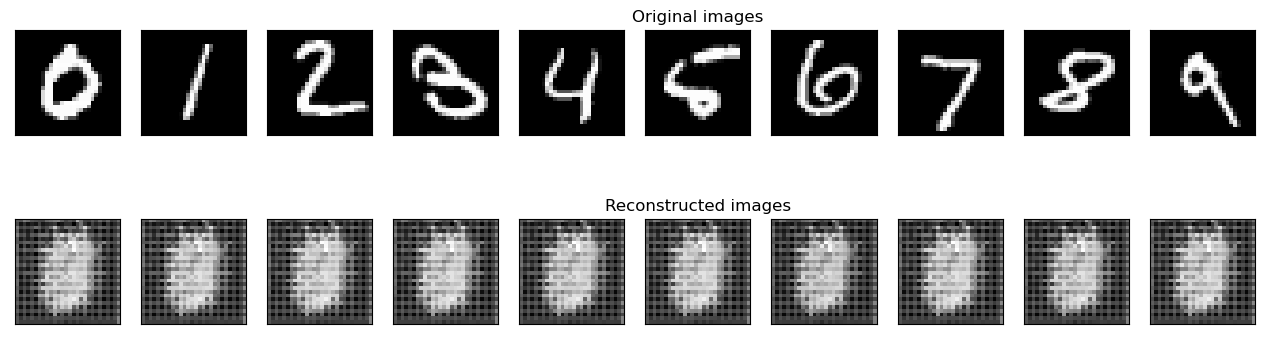

	 partial train loss (single batch): 20024.593750
	 partial train loss (single batch): 20235.054688
	 partial train loss (single batch): 19767.414062
	 partial train loss (single batch): 19634.232422
	 partial train loss (single batch): 19910.998047
	 partial train loss (single batch): 19735.687500
	 partial train loss (single batch): 19299.849609
	 partial train loss (single batch): 19578.966797
	 partial train loss (single batch): 19713.687500
	 partial train loss (single batch): 19440.990234
	 partial train loss (single batch): 19492.869141
	 partial train loss (single batch): 19241.173828
	 partial train loss (single batch): 19349.681641
	 partial train loss (single batch): 19096.849609
	 partial train loss (single batch): 18881.890625
	 partial train loss (single batch): 19039.935547
	 partial train loss (single batch): 19051.132812
	 partial train loss (single batch): 18904.480469
	 partial train loss (single batch): 18774.261719
	 partial train loss (single batch): 18622.205078


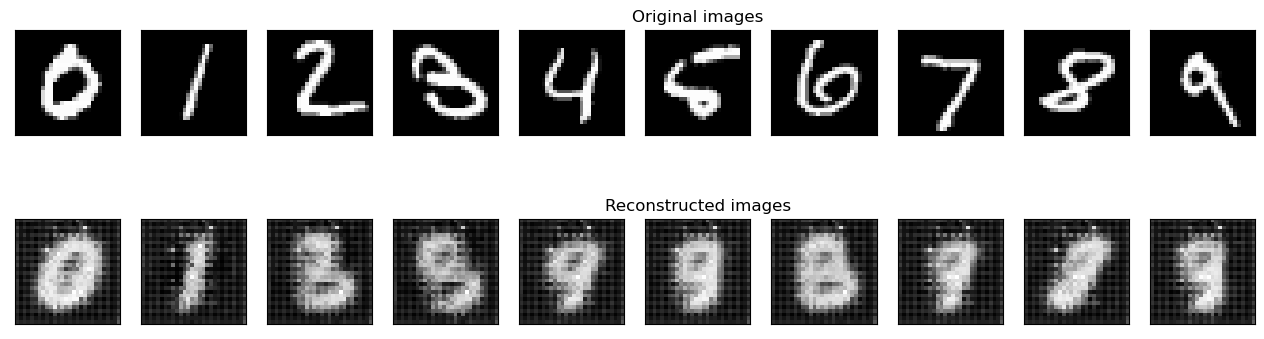

	 partial train loss (single batch): 13757.099609
	 partial train loss (single batch): 14110.233398
	 partial train loss (single batch): 13377.439453
	 partial train loss (single batch): 13355.358398
	 partial train loss (single batch): 13812.844727
	 partial train loss (single batch): 13758.523438
	 partial train loss (single batch): 13222.421875
	 partial train loss (single batch): 13614.932617
	 partial train loss (single batch): 13886.839844
	 partial train loss (single batch): 13622.068359
	 partial train loss (single batch): 13663.699219
	 partial train loss (single batch): 13441.739258
	 partial train loss (single batch): 13795.697266
	 partial train loss (single batch): 13247.716797
	 partial train loss (single batch): 13252.961914
	 partial train loss (single batch): 13376.581055
	 partial train loss (single batch): 13557.999023
	 partial train loss (single batch): 13018.786133
	 partial train loss (single batch): 13198.442383
	 partial train loss (single batch): 13092.635742


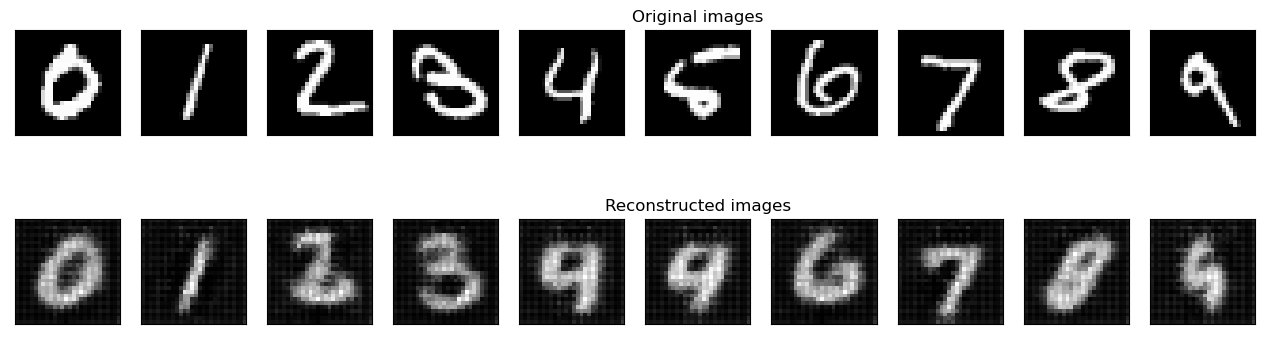

	 partial train loss (single batch): 11204.533203
	 partial train loss (single batch): 11520.340820
	 partial train loss (single batch): 10773.350586
	 partial train loss (single batch): 10704.544922
	 partial train loss (single batch): 11255.152344
	 partial train loss (single batch): 11179.463867
	 partial train loss (single batch): 10860.121094
	 partial train loss (single batch): 11067.767578
	 partial train loss (single batch): 11300.972656
	 partial train loss (single batch): 11197.074219
	 partial train loss (single batch): 11145.488281
	 partial train loss (single batch): 11002.823242
	 partial train loss (single batch): 11227.598633
	 partial train loss (single batch): 10724.118164
	 partial train loss (single batch): 10754.220703
	 partial train loss (single batch): 10982.255859
	 partial train loss (single batch): 11277.415039
	 partial train loss (single batch): 10628.191406
	 partial train loss (single batch): 10833.254883
	 partial train loss (single batch): 10829.644531


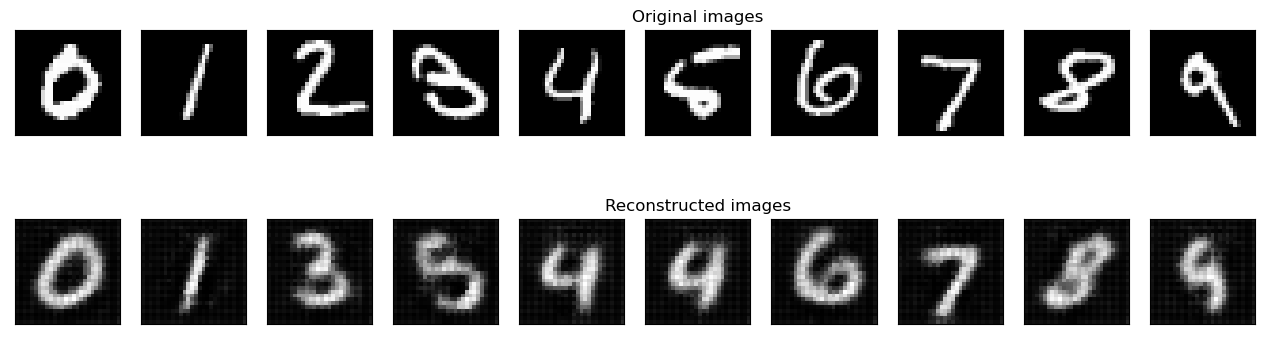

	 partial train loss (single batch): 9955.211914
	 partial train loss (single batch): 10449.605469
	 partial train loss (single batch): 9529.116211
	 partial train loss (single batch): 9560.449219
	 partial train loss (single batch): 10124.640625
	 partial train loss (single batch): 10098.395508
	 partial train loss (single batch): 9923.797852
	 partial train loss (single batch): 9901.205078
	 partial train loss (single batch): 10258.461914
	 partial train loss (single batch): 10046.017578
	 partial train loss (single batch): 10147.082031
	 partial train loss (single batch): 9904.959961
	 partial train loss (single batch): 10041.686523
	 partial train loss (single batch): 9718.749023
	 partial train loss (single batch): 9661.445312
	 partial train loss (single batch): 10004.824219
	 partial train loss (single batch): 10360.114258
	 partial train loss (single batch): 9523.547852
	 partial train loss (single batch): 9800.509766
	 partial train loss (single batch): 9813.553711
	 partial t

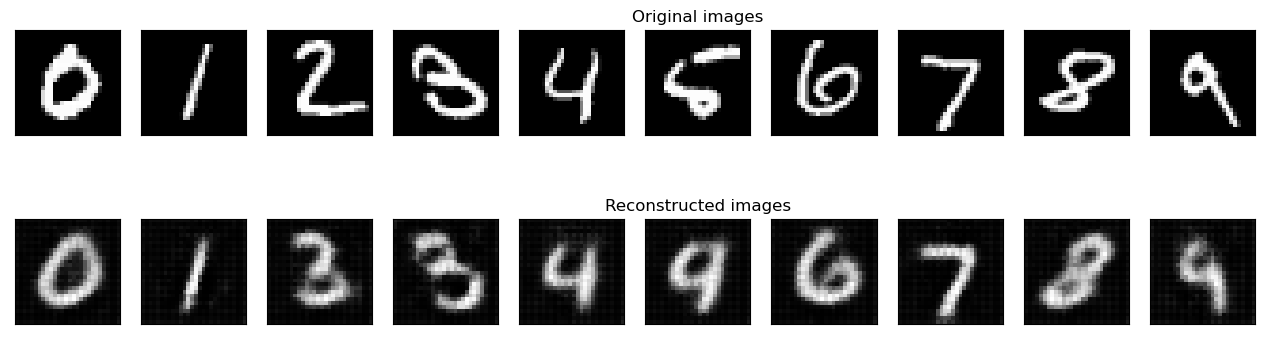

	 partial train loss (single batch): 9568.947266
	 partial train loss (single batch): 9982.892578
	 partial train loss (single batch): 9094.209961
	 partial train loss (single batch): 9152.790039
	 partial train loss (single batch): 9694.075195
	 partial train loss (single batch): 9572.833008
	 partial train loss (single batch): 9462.777344
	 partial train loss (single batch): 9527.315430
	 partial train loss (single batch): 9759.466797
	 partial train loss (single batch): 9677.572266
	 partial train loss (single batch): 9650.757812
	 partial train loss (single batch): 9507.705078
	 partial train loss (single batch): 9663.645508
	 partial train loss (single batch): 9191.578125
	 partial train loss (single batch): 9283.273438
	 partial train loss (single batch): 9647.368164
	 partial train loss (single batch): 9945.354492
	 partial train loss (single batch): 9137.082031
	 partial train loss (single batch): 9374.618164
	 partial train loss (single batch): 9380.153320
	 partial train loss

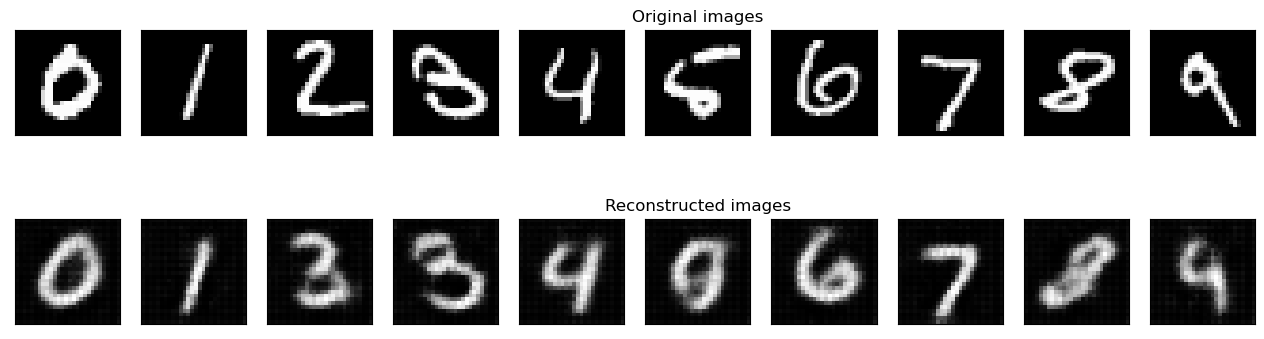

	 partial train loss (single batch): 9271.021484
	 partial train loss (single batch): 9841.192383
	 partial train loss (single batch): 8885.105469
	 partial train loss (single batch): 8798.920898
	 partial train loss (single batch): 9504.511719
	 partial train loss (single batch): 9412.512695
	 partial train loss (single batch): 9170.537109
	 partial train loss (single batch): 9376.400391
	 partial train loss (single batch): 9531.722656
	 partial train loss (single batch): 9372.061523
	 partial train loss (single batch): 9379.466797
	 partial train loss (single batch): 9238.330078
	 partial train loss (single batch): 9454.906250
	 partial train loss (single batch): 9025.452148
	 partial train loss (single batch): 9020.936523
	 partial train loss (single batch): 9350.642578
	 partial train loss (single batch): 9729.007812
	 partial train loss (single batch): 8968.257812
	 partial train loss (single batch): 9145.597656
	 partial train loss (single batch): 9144.501953
	 partial train loss

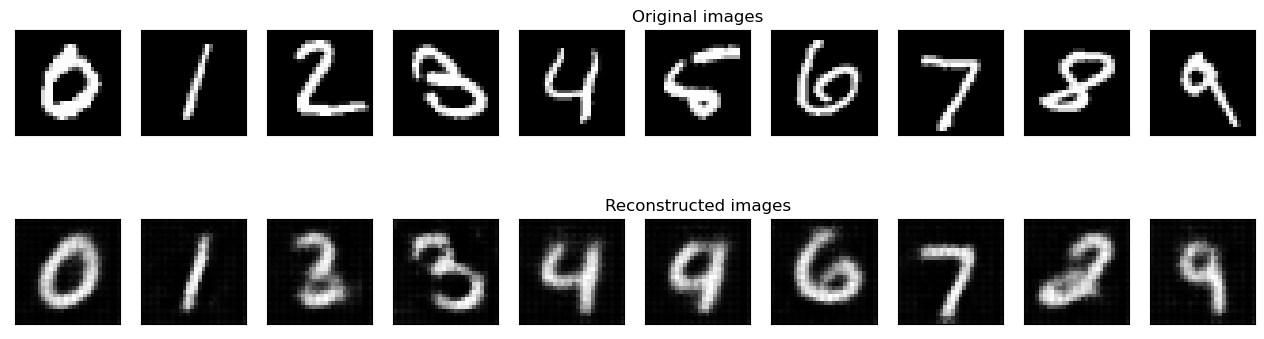

	 partial train loss (single batch): 9138.751953
	 partial train loss (single batch): 9736.851562
	 partial train loss (single batch): 8672.774414
	 partial train loss (single batch): 8685.863281
	 partial train loss (single batch): 9312.076172
	 partial train loss (single batch): 9229.541016
	 partial train loss (single batch): 8971.180664
	 partial train loss (single batch): 9157.132812
	 partial train loss (single batch): 9360.832031
	 partial train loss (single batch): 9241.223633
	 partial train loss (single batch): 9191.572266
	 partial train loss (single batch): 9122.663086
	 partial train loss (single batch): 9330.595703
	 partial train loss (single batch): 8920.462891
	 partial train loss (single batch): 8876.410156
	 partial train loss (single batch): 9187.937500
	 partial train loss (single batch): 9630.647461
	 partial train loss (single batch): 8799.353516
	 partial train loss (single batch): 9077.814453
	 partial train loss (single batch): 8975.214844
	 partial train loss

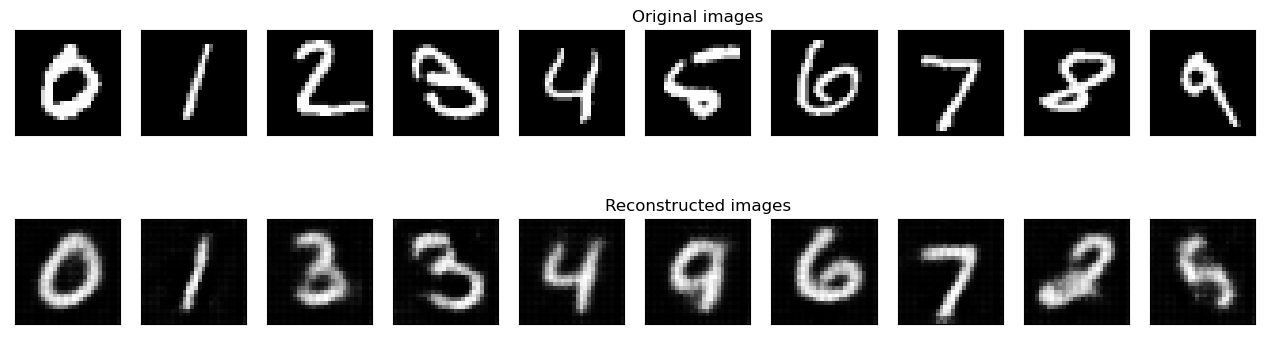

	 partial train loss (single batch): 9009.708984
	 partial train loss (single batch): 9508.743164
	 partial train loss (single batch): 8592.156250
	 partial train loss (single batch): 8600.919922
	 partial train loss (single batch): 9113.902344
	 partial train loss (single batch): 9051.914062
	 partial train loss (single batch): 8945.451172
	 partial train loss (single batch): 9029.951172
	 partial train loss (single batch): 9189.539062
	 partial train loss (single batch): 9126.802734
	 partial train loss (single batch): 9063.891602
	 partial train loss (single batch): 8994.363281
	 partial train loss (single batch): 9228.150391
	 partial train loss (single batch): 8829.942383
	 partial train loss (single batch): 8668.982422
	 partial train loss (single batch): 9077.219727
	 partial train loss (single batch): 9436.226562
	 partial train loss (single batch): 8684.451172
	 partial train loss (single batch): 8912.417969
	 partial train loss (single batch): 8987.174805
	 partial train loss

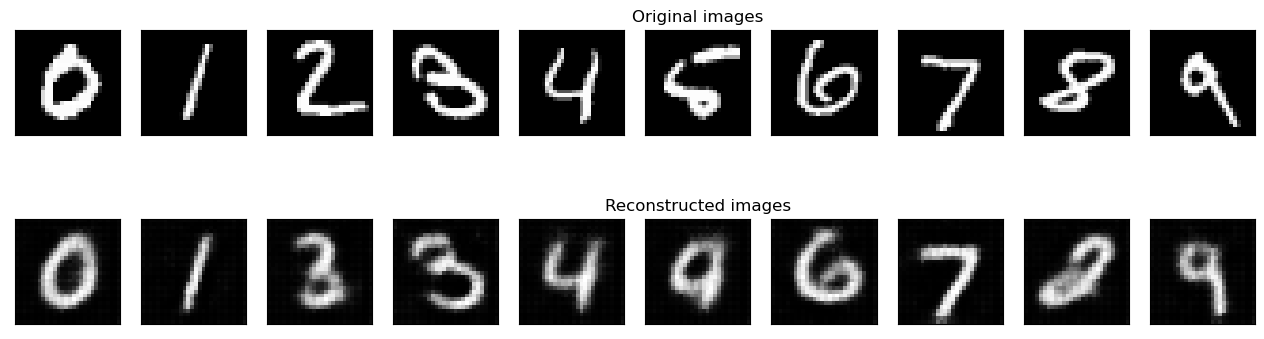

	 partial train loss (single batch): 9000.534180
	 partial train loss (single batch): 9416.093750
	 partial train loss (single batch): 8525.845703
	 partial train loss (single batch): 8609.803711
	 partial train loss (single batch): 9064.248047
	 partial train loss (single batch): 8983.433594
	 partial train loss (single batch): 8837.097656
	 partial train loss (single batch): 9042.013672
	 partial train loss (single batch): 9246.422852
	 partial train loss (single batch): 9020.078125
	 partial train loss (single batch): 9115.410156
	 partial train loss (single batch): 8919.704102
	 partial train loss (single batch): 9205.813477
	 partial train loss (single batch): 8682.339844
	 partial train loss (single batch): 8682.061523
	 partial train loss (single batch): 9029.796875
	 partial train loss (single batch): 9369.494141
	 partial train loss (single batch): 8597.249023
	 partial train loss (single batch): 8830.601562
	 partial train loss (single batch): 8804.864258
	 partial train loss

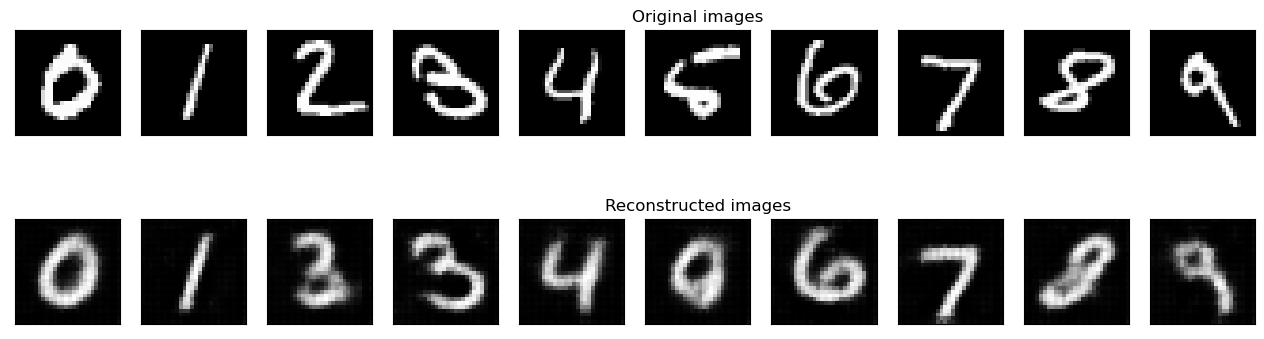

	 partial train loss (single batch): 8887.896484
	 partial train loss (single batch): 9413.624023
	 partial train loss (single batch): 8438.885742
	 partial train loss (single batch): 8541.896484
	 partial train loss (single batch): 8954.666992
	 partial train loss (single batch): 8971.795898
	 partial train loss (single batch): 8707.794922
	 partial train loss (single batch): 8883.674805
	 partial train loss (single batch): 9103.416016
	 partial train loss (single batch): 9000.550781
	 partial train loss (single batch): 8942.359375
	 partial train loss (single batch): 8837.383789
	 partial train loss (single batch): 9120.578125
	 partial train loss (single batch): 8644.134766
	 partial train loss (single batch): 8632.730469
	 partial train loss (single batch): 9058.132812
	 partial train loss (single batch): 9342.722656
	 partial train loss (single batch): 8584.544922
	 partial train loss (single batch): 8729.689453
	 partial train loss (single batch): 8692.619141
	 partial train loss

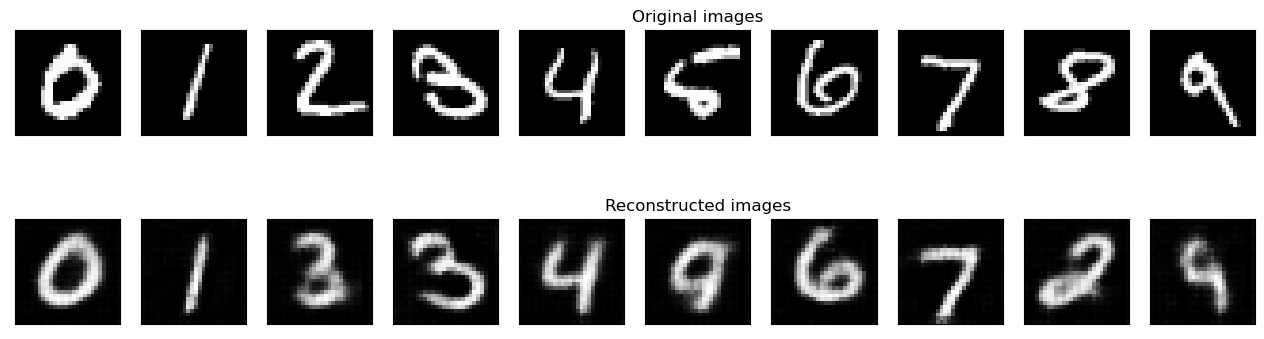

	 partial train loss (single batch): 8814.671875
	 partial train loss (single batch): 9320.209961
	 partial train loss (single batch): 8431.421875
	 partial train loss (single batch): 8458.043945
	 partial train loss (single batch): 8934.080078
	 partial train loss (single batch): 8847.480469
	 partial train loss (single batch): 8753.006836
	 partial train loss (single batch): 8862.449219
	 partial train loss (single batch): 8993.476562
	 partial train loss (single batch): 9018.765625
	 partial train loss (single batch): 8848.132812
	 partial train loss (single batch): 8780.626953
	 partial train loss (single batch): 9170.153320
	 partial train loss (single batch): 8593.574219
	 partial train loss (single batch): 8595.219727
	 partial train loss (single batch): 8940.122070
	 partial train loss (single batch): 9235.805664
	 partial train loss (single batch): 8598.416016
	 partial train loss (single batch): 8778.565430
	 partial train loss (single batch): 8698.400391
	 partial train loss

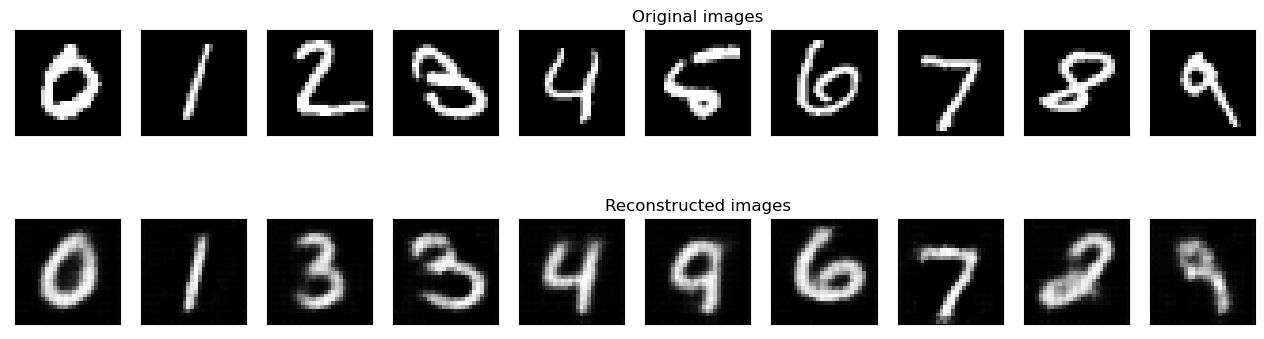

	 partial train loss (single batch): 8769.883789
	 partial train loss (single batch): 9241.677734
	 partial train loss (single batch): 8381.833984
	 partial train loss (single batch): 8386.148438
	 partial train loss (single batch): 8887.523438
	 partial train loss (single batch): 8819.863281
	 partial train loss (single batch): 8746.701172
	 partial train loss (single batch): 8840.183594
	 partial train loss (single batch): 8984.314453
	 partial train loss (single batch): 8931.267578
	 partial train loss (single batch): 8831.682617
	 partial train loss (single batch): 8706.790039
	 partial train loss (single batch): 9074.174805
	 partial train loss (single batch): 8499.504883
	 partial train loss (single batch): 8526.250977
	 partial train loss (single batch): 8798.060547
	 partial train loss (single batch): 9188.738281
	 partial train loss (single batch): 8424.722656
	 partial train loss (single batch): 8721.623047
	 partial train loss (single batch): 8610.158203
	 partial train loss

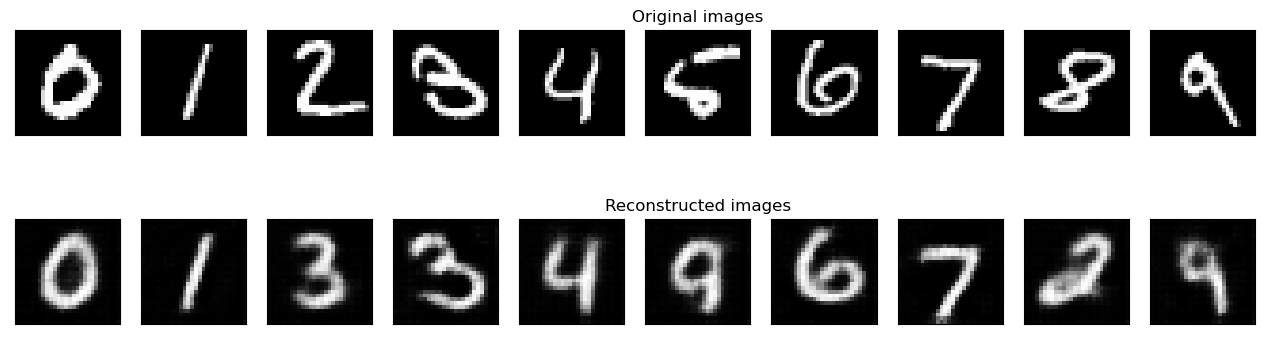

	 partial train loss (single batch): 8727.939453
	 partial train loss (single batch): 9257.737305
	 partial train loss (single batch): 8310.562500
	 partial train loss (single batch): 8297.837891
	 partial train loss (single batch): 8811.348633
	 partial train loss (single batch): 8780.753906
	 partial train loss (single batch): 8683.263672
	 partial train loss (single batch): 8835.266602
	 partial train loss (single batch): 8937.480469
	 partial train loss (single batch): 8872.736328
	 partial train loss (single batch): 8817.854492
	 partial train loss (single batch): 8656.916016
	 partial train loss (single batch): 8997.475586
	 partial train loss (single batch): 8507.009766
	 partial train loss (single batch): 8497.902344
	 partial train loss (single batch): 8910.671875
	 partial train loss (single batch): 9338.729492
	 partial train loss (single batch): 8428.803711
	 partial train loss (single batch): 8676.435547
	 partial train loss (single batch): 8668.937500
	 partial train loss

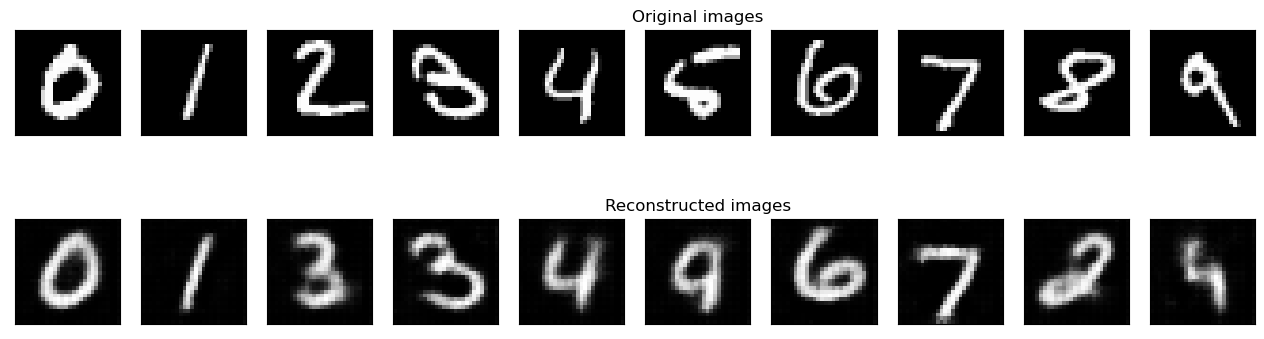

	 partial train loss (single batch): 8735.298828
	 partial train loss (single batch): 9280.041992
	 partial train loss (single batch): 8264.366211
	 partial train loss (single batch): 8331.642578
	 partial train loss (single batch): 8771.910156
	 partial train loss (single batch): 8828.026367
	 partial train loss (single batch): 8639.407227
	 partial train loss (single batch): 8798.055664
	 partial train loss (single batch): 8871.298828
	 partial train loss (single batch): 8777.530273
	 partial train loss (single batch): 8687.257812
	 partial train loss (single batch): 8636.009766
	 partial train loss (single batch): 8955.125000
	 partial train loss (single batch): 8429.054688
	 partial train loss (single batch): 8429.300781
	 partial train loss (single batch): 8884.352539
	 partial train loss (single batch): 9163.390625
	 partial train loss (single batch): 8415.593750
	 partial train loss (single batch): 8623.285156
	 partial train loss (single batch): 8639.317383
	 partial train loss

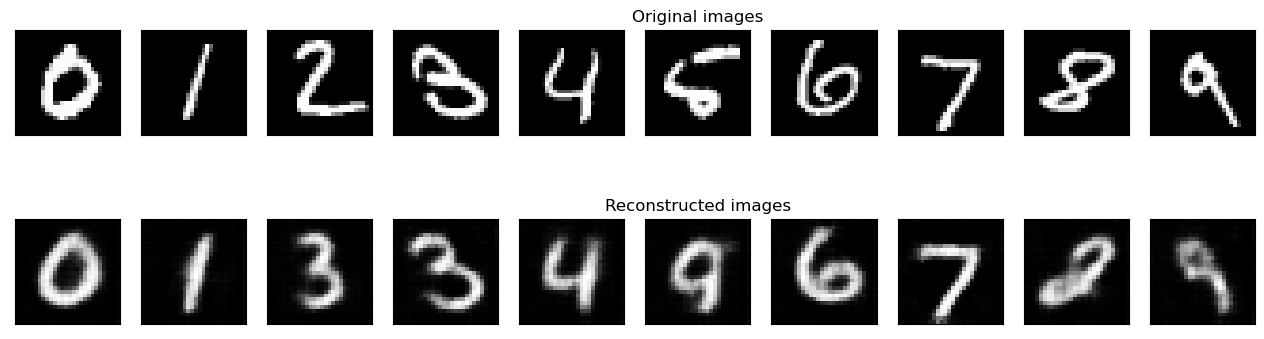

	 partial train loss (single batch): 8669.261719
	 partial train loss (single batch): 9213.260742
	 partial train loss (single batch): 8303.160156
	 partial train loss (single batch): 8278.987305
	 partial train loss (single batch): 8750.253906
	 partial train loss (single batch): 8789.194336
	 partial train loss (single batch): 8630.105469
	 partial train loss (single batch): 8786.669922
	 partial train loss (single batch): 8845.365234
	 partial train loss (single batch): 8848.578125
	 partial train loss (single batch): 8753.869141
	 partial train loss (single batch): 8658.937500
	 partial train loss (single batch): 8950.842773
	 partial train loss (single batch): 8524.455078
	 partial train loss (single batch): 8470.525391
	 partial train loss (single batch): 8820.042969
	 partial train loss (single batch): 9154.531250
	 partial train loss (single batch): 8357.484375
	 partial train loss (single batch): 8599.240234
	 partial train loss (single batch): 8523.065430
	 partial train loss

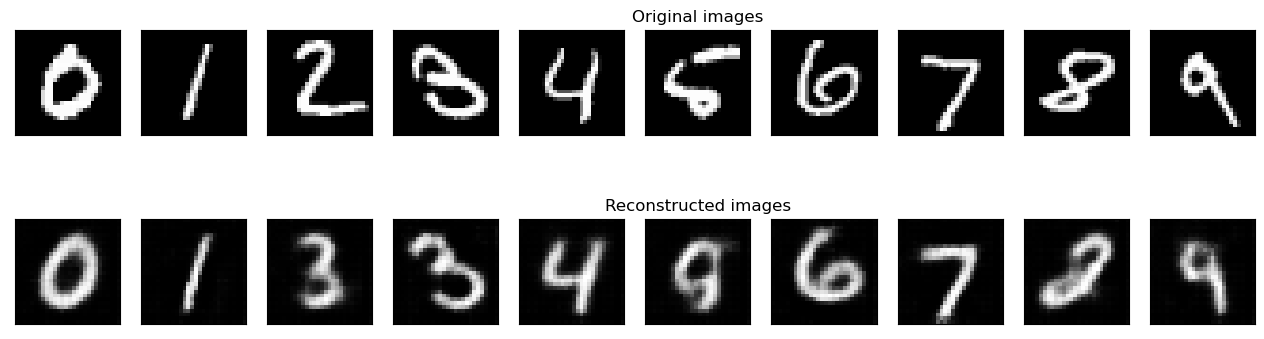

	 partial train loss (single batch): 8646.735352
	 partial train loss (single batch): 9158.718750
	 partial train loss (single batch): 8222.068359
	 partial train loss (single batch): 8283.674805
	 partial train loss (single batch): 8725.667969
	 partial train loss (single batch): 8796.968750
	 partial train loss (single batch): 8569.007812
	 partial train loss (single batch): 8829.685547
	 partial train loss (single batch): 8923.447266
	 partial train loss (single batch): 8798.141602
	 partial train loss (single batch): 8731.113281
	 partial train loss (single batch): 8565.650391
	 partial train loss (single batch): 8928.113281
	 partial train loss (single batch): 8387.478516
	 partial train loss (single batch): 8355.086914
	 partial train loss (single batch): 8763.958984
	 partial train loss (single batch): 9018.621094
	 partial train loss (single batch): 8310.882812
	 partial train loss (single batch): 8585.011719
	 partial train loss (single batch): 8586.170898
	 partial train loss

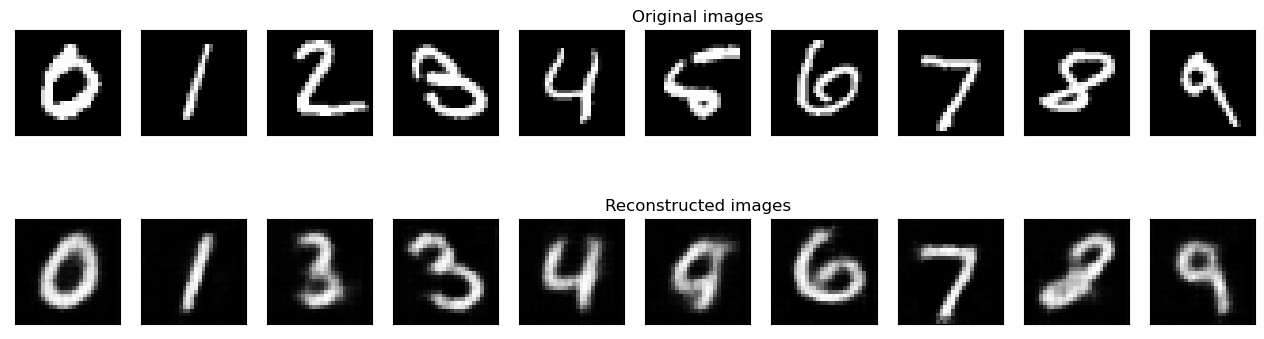

	 partial train loss (single batch): 8554.197266
	 partial train loss (single batch): 9120.574219
	 partial train loss (single batch): 8201.890625
	 partial train loss (single batch): 8261.517578
	 partial train loss (single batch): 8673.451172
	 partial train loss (single batch): 8748.949219
	 partial train loss (single batch): 8608.712891
	 partial train loss (single batch): 8694.250000
	 partial train loss (single batch): 8764.006836
	 partial train loss (single batch): 8716.339844
	 partial train loss (single batch): 8773.676758
	 partial train loss (single batch): 8587.865234
	 partial train loss (single batch): 8958.701172
	 partial train loss (single batch): 8416.414062
	 partial train loss (single batch): 8387.852539
	 partial train loss (single batch): 8723.334961
	 partial train loss (single batch): 9108.737305
	 partial train loss (single batch): 8234.029297
	 partial train loss (single batch): 8534.667969
	 partial train loss (single batch): 8665.525391
	 partial train loss

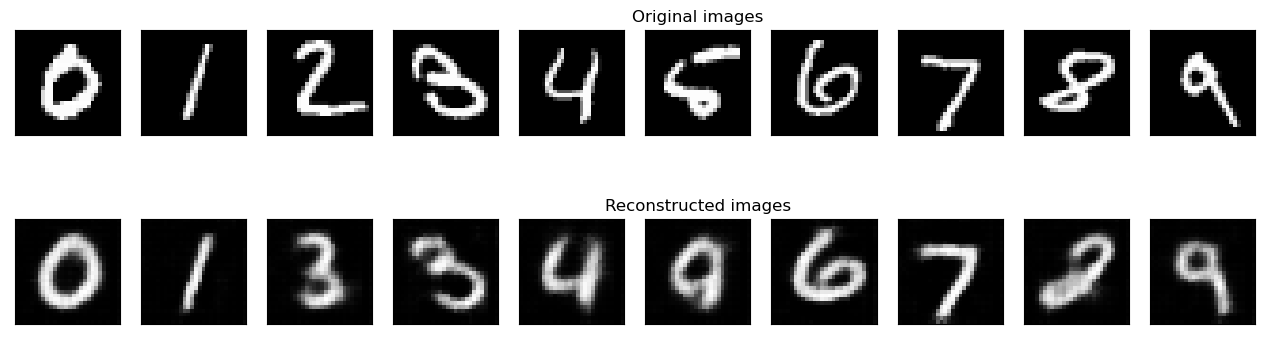

	 partial train loss (single batch): 8589.256836
	 partial train loss (single batch): 9091.782227
	 partial train loss (single batch): 8174.804688
	 partial train loss (single batch): 8201.819336
	 partial train loss (single batch): 8643.875977
	 partial train loss (single batch): 8722.158203
	 partial train loss (single batch): 8601.867188
	 partial train loss (single batch): 8715.586914
	 partial train loss (single batch): 8778.841797
	 partial train loss (single batch): 8671.755859
	 partial train loss (single batch): 8671.399414
	 partial train loss (single batch): 8558.333984
	 partial train loss (single batch): 8824.767578
	 partial train loss (single batch): 8367.105469
	 partial train loss (single batch): 8370.210938
	 partial train loss (single batch): 8737.089844
	 partial train loss (single batch): 9008.625977
	 partial train loss (single batch): 8301.021484
	 partial train loss (single batch): 8540.817383
	 partial train loss (single batch): 8555.896484
	 partial train loss

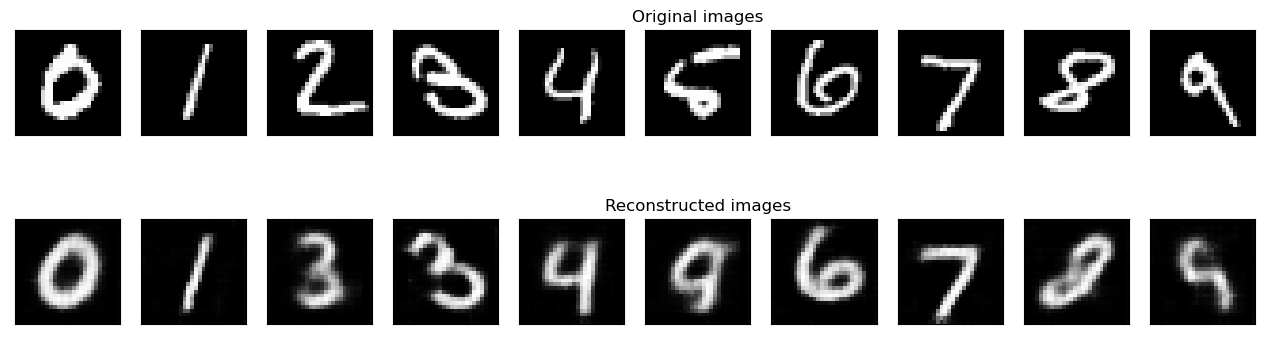

	 partial train loss (single batch): 8532.644531
	 partial train loss (single batch): 9049.151367
	 partial train loss (single batch): 8187.367676
	 partial train loss (single batch): 8204.359375
	 partial train loss (single batch): 8703.854492
	 partial train loss (single batch): 8693.096680
	 partial train loss (single batch): 8507.188477
	 partial train loss (single batch): 8650.086914
	 partial train loss (single batch): 8649.707031
	 partial train loss (single batch): 8729.441406
	 partial train loss (single batch): 8606.544922
	 partial train loss (single batch): 8545.811523
	 partial train loss (single batch): 8818.778320
	 partial train loss (single batch): 8394.841797
	 partial train loss (single batch): 8411.398438
	 partial train loss (single batch): 8679.178711
	 partial train loss (single batch): 8913.313477
	 partial train loss (single batch): 8326.913086
	 partial train loss (single batch): 8557.144531
	 partial train loss (single batch): 8469.322266
	 partial train loss

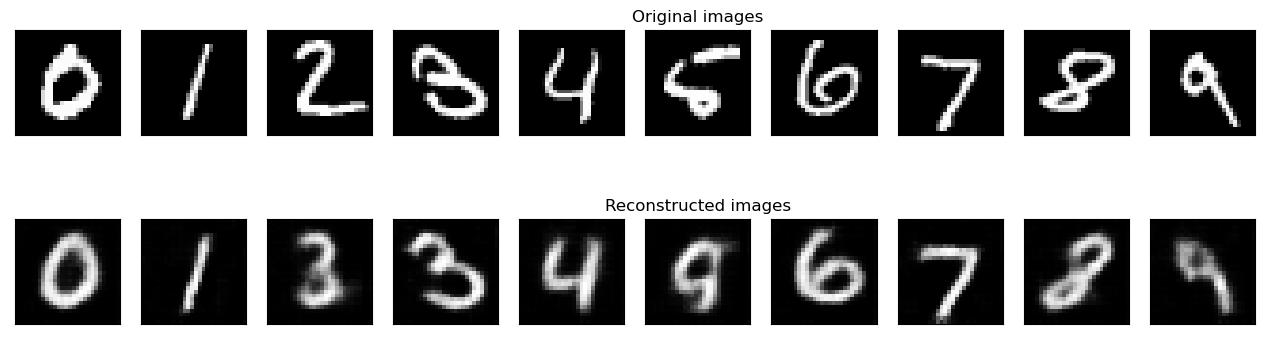

	 partial train loss (single batch): 8510.681641
	 partial train loss (single batch): 9004.300781
	 partial train loss (single batch): 8160.715820
	 partial train loss (single batch): 8136.256348
	 partial train loss (single batch): 8688.654297
	 partial train loss (single batch): 8691.678711
	 partial train loss (single batch): 8489.452148
	 partial train loss (single batch): 8713.644531
	 partial train loss (single batch): 8668.460938
	 partial train loss (single batch): 8775.233398
	 partial train loss (single batch): 8558.578125
	 partial train loss (single batch): 8458.164062
	 partial train loss (single batch): 8833.774414
	 partial train loss (single batch): 8289.390625
	 partial train loss (single batch): 8354.783203
	 partial train loss (single batch): 8756.904297
	 partial train loss (single batch): 9027.551758
	 partial train loss (single batch): 8269.397461
	 partial train loss (single batch): 8570.070312
	 partial train loss (single batch): 8543.445312
	 partial train loss

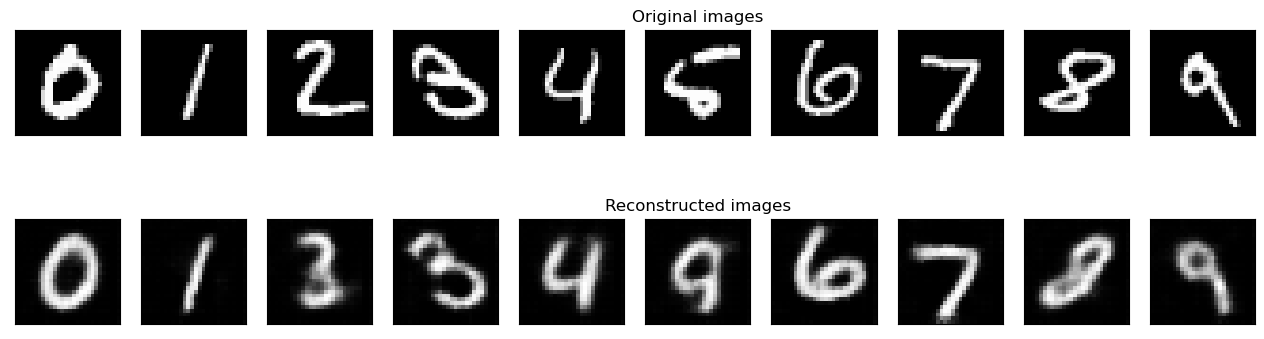

	 partial train loss (single batch): 8506.337891
	 partial train loss (single batch): 8996.565430
	 partial train loss (single batch): 8101.355469
	 partial train loss (single batch): 8109.541016
	 partial train loss (single batch): 8686.408203
	 partial train loss (single batch): 8618.334961
	 partial train loss (single batch): 8525.463867
	 partial train loss (single batch): 8595.315430
	 partial train loss (single batch): 8692.498047
	 partial train loss (single batch): 8599.455078
	 partial train loss (single batch): 8667.365234
	 partial train loss (single batch): 8551.750000
	 partial train loss (single batch): 8820.267578
	 partial train loss (single batch): 8258.857422
	 partial train loss (single batch): 8272.576172
	 partial train loss (single batch): 8676.851562
	 partial train loss (single batch): 8942.839844
	 partial train loss (single batch): 8205.855469
	 partial train loss (single batch): 8529.300781
	 partial train loss (single batch): 8466.482422
	 partial train loss

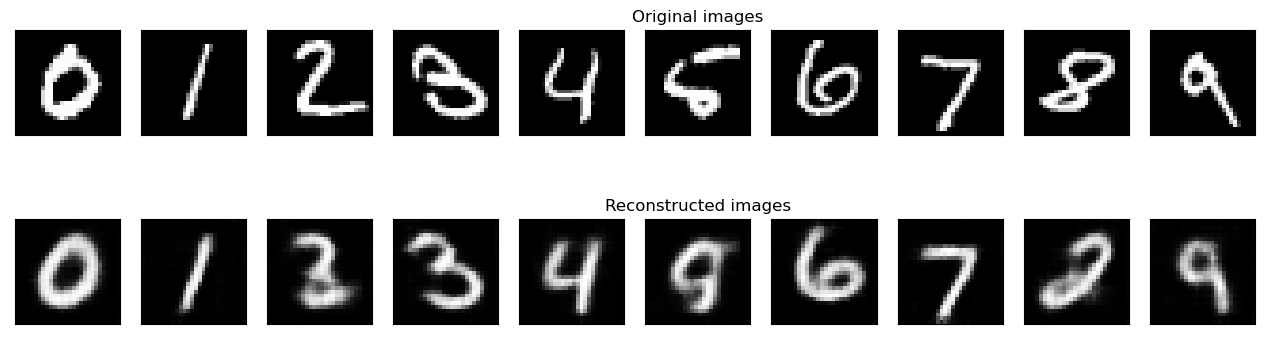

	 partial train loss (single batch): 8512.762695
	 partial train loss (single batch): 8977.070312
	 partial train loss (single batch): 8077.392578
	 partial train loss (single batch): 8116.532227
	 partial train loss (single batch): 8609.103516
	 partial train loss (single batch): 8572.174805
	 partial train loss (single batch): 8447.888672
	 partial train loss (single batch): 8568.401367
	 partial train loss (single batch): 8694.986328
	 partial train loss (single batch): 8607.226562
	 partial train loss (single batch): 8656.461914
	 partial train loss (single batch): 8464.942383
	 partial train loss (single batch): 8740.160156
	 partial train loss (single batch): 8269.164062
	 partial train loss (single batch): 8279.308594
	 partial train loss (single batch): 8627.072266
	 partial train loss (single batch): 8925.412109
	 partial train loss (single batch): 8217.478516
	 partial train loss (single batch): 8386.833008
	 partial train loss (single batch): 8418.763672
	 partial train loss

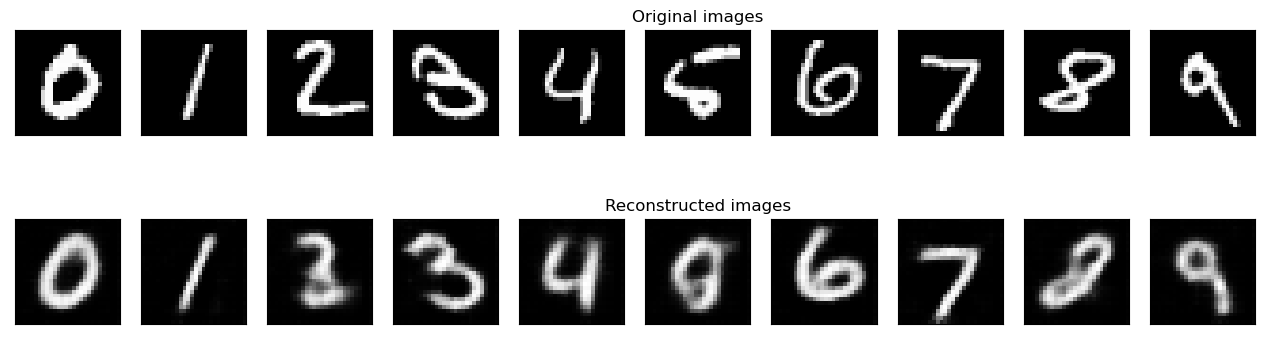

	 partial train loss (single batch): 8494.390625
	 partial train loss (single batch): 8961.659180
	 partial train loss (single batch): 8115.974609
	 partial train loss (single batch): 8186.869141
	 partial train loss (single batch): 8582.958984
	 partial train loss (single batch): 8605.131836
	 partial train loss (single batch): 8445.430664
	 partial train loss (single batch): 8562.375000
	 partial train loss (single batch): 8642.585938
	 partial train loss (single batch): 8581.419922
	 partial train loss (single batch): 8556.960938
	 partial train loss (single batch): 8421.023438
	 partial train loss (single batch): 8719.721680
	 partial train loss (single batch): 8235.064453
	 partial train loss (single batch): 8233.529297
	 partial train loss (single batch): 8648.427734
	 partial train loss (single batch): 8887.336914
	 partial train loss (single batch): 8171.468262
	 partial train loss (single batch): 8415.218750
	 partial train loss (single batch): 8370.626953
	 partial train loss

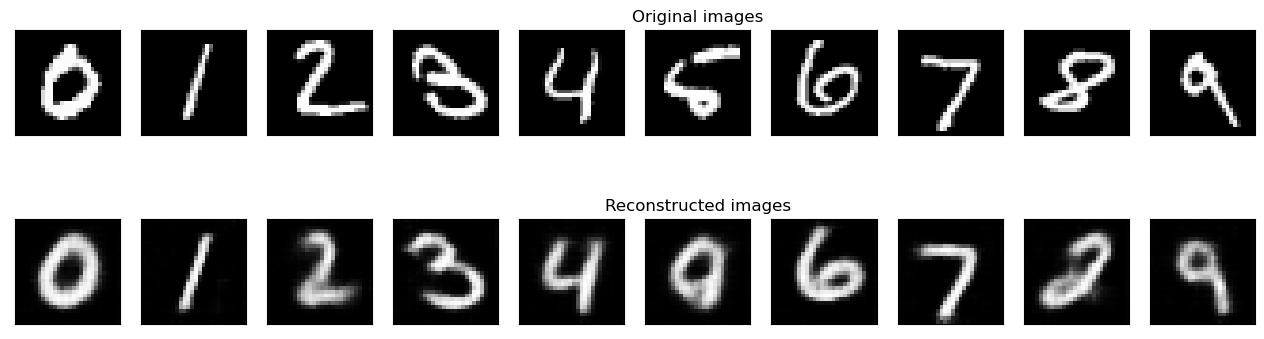

	 partial train loss (single batch): 8399.374023
	 partial train loss (single batch): 8950.337891
	 partial train loss (single batch): 8111.573242
	 partial train loss (single batch): 8142.169922
	 partial train loss (single batch): 8598.675781
	 partial train loss (single batch): 8547.774414
	 partial train loss (single batch): 8481.227539
	 partial train loss (single batch): 8557.571289
	 partial train loss (single batch): 8665.843750
	 partial train loss (single batch): 8619.107422
	 partial train loss (single batch): 8528.223633
	 partial train loss (single batch): 8418.416016
	 partial train loss (single batch): 8729.360352
	 partial train loss (single batch): 8268.634766
	 partial train loss (single batch): 8256.275391
	 partial train loss (single batch): 8590.419922
	 partial train loss (single batch): 8905.916992
	 partial train loss (single batch): 8218.905273
	 partial train loss (single batch): 8443.015625
	 partial train loss (single batch): 8420.901367
	 partial train loss

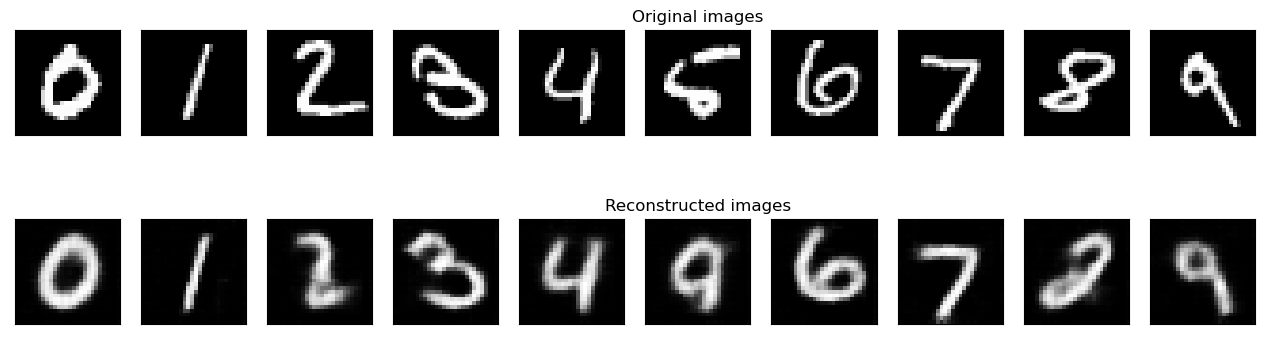

	 partial train loss (single batch): 8482.741211
	 partial train loss (single batch): 8936.675781
	 partial train loss (single batch): 8074.097168
	 partial train loss (single batch): 8155.125977
	 partial train loss (single batch): 8582.951172
	 partial train loss (single batch): 8523.922852
	 partial train loss (single batch): 8417.725586
	 partial train loss (single batch): 8543.493164
	 partial train loss (single batch): 8637.406250
	 partial train loss (single batch): 8522.064453
	 partial train loss (single batch): 8547.265625
	 partial train loss (single batch): 8451.806641
	 partial train loss (single batch): 8725.007812
	 partial train loss (single batch): 8269.061523
	 partial train loss (single batch): 8254.521484
	 partial train loss (single batch): 8580.964844
	 partial train loss (single batch): 8877.687500
	 partial train loss (single batch): 8160.742188
	 partial train loss (single batch): 8439.497070
	 partial train loss (single batch): 8413.390625
	 partial train loss

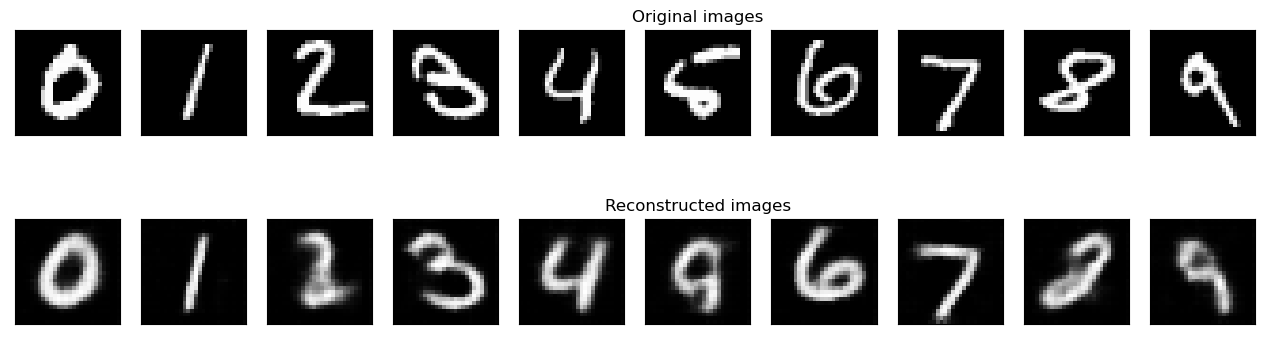

	 partial train loss (single batch): 8483.287109
	 partial train loss (single batch): 8993.585938
	 partial train loss (single batch): 8090.872559
	 partial train loss (single batch): 8004.052734
	 partial train loss (single batch): 8607.914062
	 partial train loss (single batch): 8578.796875
	 partial train loss (single batch): 8473.138672
	 partial train loss (single batch): 8526.009766
	 partial train loss (single batch): 8632.825195
	 partial train loss (single batch): 8581.830078
	 partial train loss (single batch): 8577.944336
	 partial train loss (single batch): 8443.287109
	 partial train loss (single batch): 8754.268555
	 partial train loss (single batch): 8258.445312
	 partial train loss (single batch): 8342.859375
	 partial train loss (single batch): 8615.889648
	 partial train loss (single batch): 8902.578125
	 partial train loss (single batch): 8169.423340
	 partial train loss (single batch): 8456.304688
	 partial train loss (single batch): 8356.729492
	 partial train loss

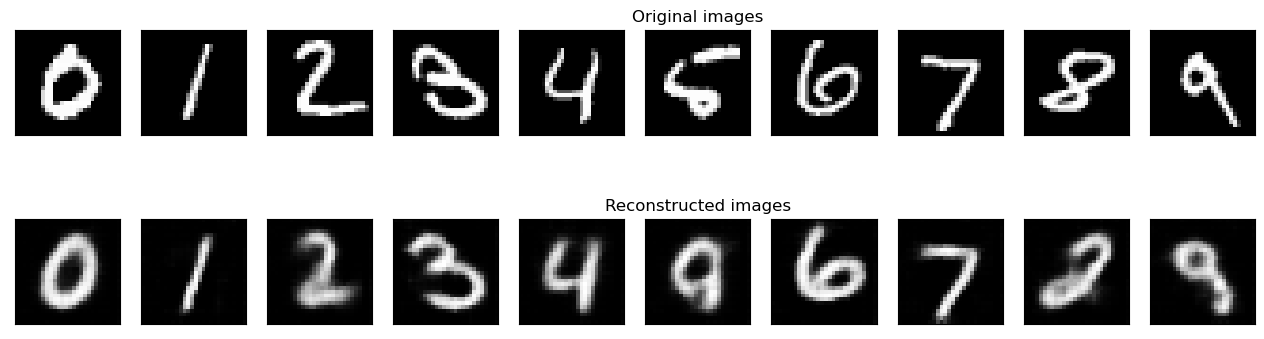

	 partial train loss (single batch): 8432.715820
	 partial train loss (single batch): 8915.718750
	 partial train loss (single batch): 8070.972168
	 partial train loss (single batch): 8069.306641
	 partial train loss (single batch): 8600.210938
	 partial train loss (single batch): 8468.612305
	 partial train loss (single batch): 8455.201172
	 partial train loss (single batch): 8547.179688
	 partial train loss (single batch): 8686.659180
	 partial train loss (single batch): 8546.852539
	 partial train loss (single batch): 8533.623047
	 partial train loss (single batch): 8387.004883
	 partial train loss (single batch): 8740.411133
	 partial train loss (single batch): 8130.893555
	 partial train loss (single batch): 8194.320312
	 partial train loss (single batch): 8526.335938
	 partial train loss (single batch): 8823.073242
	 partial train loss (single batch): 8171.060059
	 partial train loss (single batch): 8490.154297
	 partial train loss (single batch): 8350.213867
	 partial train loss

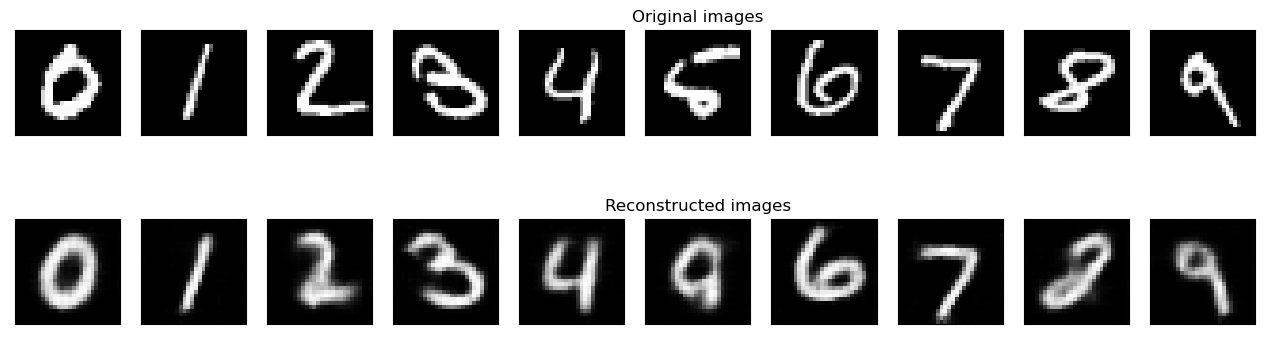

	 partial train loss (single batch): 8406.744141
	 partial train loss (single batch): 8872.180664
	 partial train loss (single batch): 8033.933594
	 partial train loss (single batch): 8022.210938
	 partial train loss (single batch): 8478.770508
	 partial train loss (single batch): 8590.558594
	 partial train loss (single batch): 8427.713867
	 partial train loss (single batch): 8576.271484
	 partial train loss (single batch): 8678.716797
	 partial train loss (single batch): 8535.493164
	 partial train loss (single batch): 8567.210938
	 partial train loss (single batch): 8391.400391
	 partial train loss (single batch): 8715.506836
	 partial train loss (single batch): 8163.390625
	 partial train loss (single batch): 8258.200195
	 partial train loss (single batch): 8567.679688
	 partial train loss (single batch): 8954.537109
	 partial train loss (single batch): 8099.681641
	 partial train loss (single batch): 8436.604492
	 partial train loss (single batch): 8417.149414
	 partial train loss

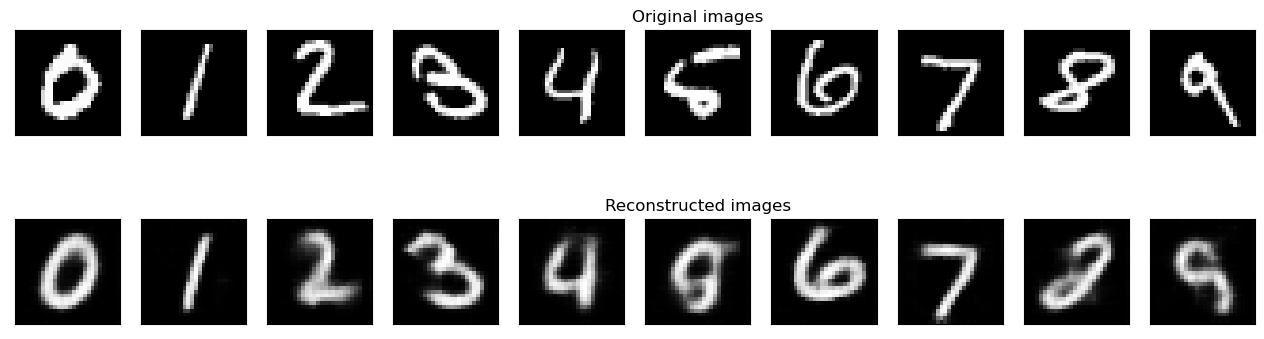

	 partial train loss (single batch): 8311.169922
	 partial train loss (single batch): 8948.544922
	 partial train loss (single batch): 8088.419434
	 partial train loss (single batch): 8073.958496
	 partial train loss (single batch): 8536.458984
	 partial train loss (single batch): 8519.164062
	 partial train loss (single batch): 8370.158203
	 partial train loss (single batch): 8481.028320
	 partial train loss (single batch): 8588.615234
	 partial train loss (single batch): 8504.105469
	 partial train loss (single batch): 8480.567383
	 partial train loss (single batch): 8351.176758
	 partial train loss (single batch): 8699.273438
	 partial train loss (single batch): 8197.925781
	 partial train loss (single batch): 8159.925781
	 partial train loss (single batch): 8618.820312
	 partial train loss (single batch): 8784.274414
	 partial train loss (single batch): 8093.938477
	 partial train loss (single batch): 8334.803711
	 partial train loss (single batch): 8360.410156
	 partial train loss

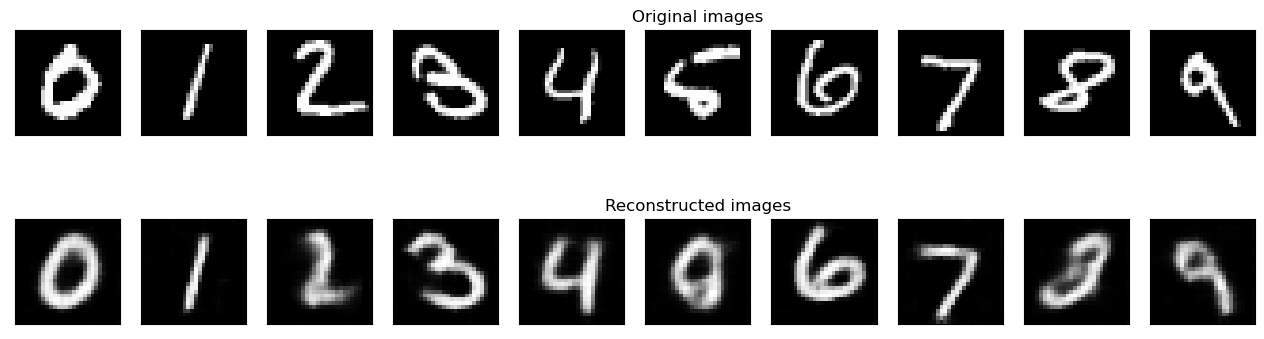

	 partial train loss (single batch): 8324.527344
	 partial train loss (single batch): 8877.322266
	 partial train loss (single batch): 8009.589844
	 partial train loss (single batch): 8052.683594
	 partial train loss (single batch): 8525.042969
	 partial train loss (single batch): 8503.114258
	 partial train loss (single batch): 8382.460938
	 partial train loss (single batch): 8469.474609
	 partial train loss (single batch): 8572.769531
	 partial train loss (single batch): 8450.068359
	 partial train loss (single batch): 8468.818359
	 partial train loss (single batch): 8339.908203
	 partial train loss (single batch): 8668.681641
	 partial train loss (single batch): 8141.969238
	 partial train loss (single batch): 8166.555664
	 partial train loss (single batch): 8527.050781
	 partial train loss (single batch): 8832.290039
	 partial train loss (single batch): 8140.934570
	 partial train loss (single batch): 8333.537109
	 partial train loss (single batch): 8331.652344
	 partial train loss

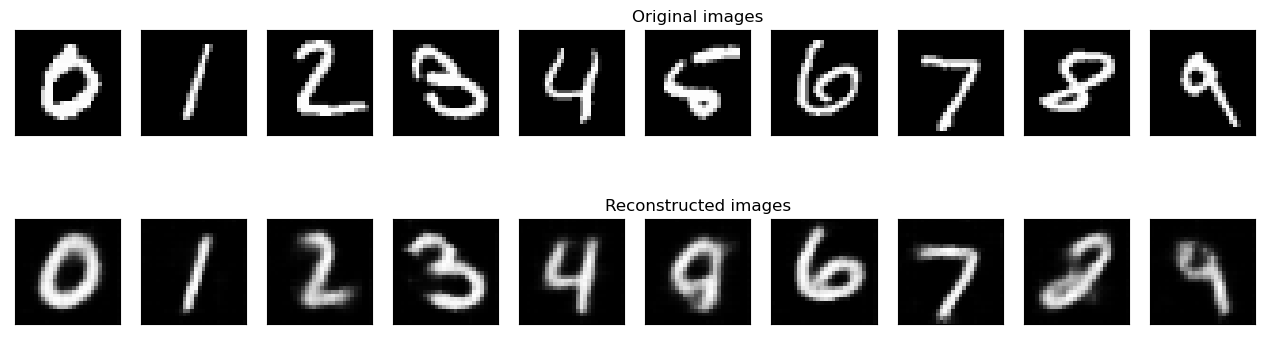

	 partial train loss (single batch): 8304.986328
	 partial train loss (single batch): 8881.304688
	 partial train loss (single batch): 7977.579102
	 partial train loss (single batch): 7998.586426
	 partial train loss (single batch): 8521.134766
	 partial train loss (single batch): 8504.925781
	 partial train loss (single batch): 8378.441406
	 partial train loss (single batch): 8499.902344
	 partial train loss (single batch): 8568.766602
	 partial train loss (single batch): 8464.919922
	 partial train loss (single batch): 8500.085938
	 partial train loss (single batch): 8364.637695
	 partial train loss (single batch): 8605.339844
	 partial train loss (single batch): 8088.777832
	 partial train loss (single batch): 8181.548828
	 partial train loss (single batch): 8576.621094
	 partial train loss (single batch): 8864.609375
	 partial train loss (single batch): 8094.550293
	 partial train loss (single batch): 8391.753906
	 partial train loss (single batch): 8407.261719
	 partial train loss

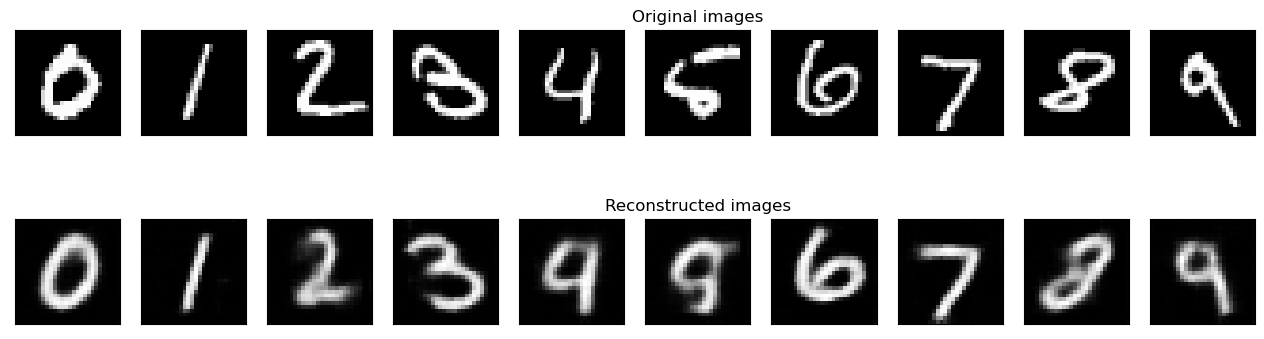

	 partial train loss (single batch): 8320.460938
	 partial train loss (single batch): 8837.750000
	 partial train loss (single batch): 7956.335938
	 partial train loss (single batch): 8004.006836
	 partial train loss (single batch): 8508.966797
	 partial train loss (single batch): 8475.816406
	 partial train loss (single batch): 8336.330078
	 partial train loss (single batch): 8503.867188
	 partial train loss (single batch): 8544.642578
	 partial train loss (single batch): 8494.324219
	 partial train loss (single batch): 8413.743164
	 partial train loss (single batch): 8295.015625
	 partial train loss (single batch): 8665.554688
	 partial train loss (single batch): 8121.667969
	 partial train loss (single batch): 8186.394531
	 partial train loss (single batch): 8576.828125
	 partial train loss (single batch): 8844.288086
	 partial train loss (single batch): 8090.809082
	 partial train loss (single batch): 8377.106445
	 partial train loss (single batch): 8272.505859
	 partial train loss

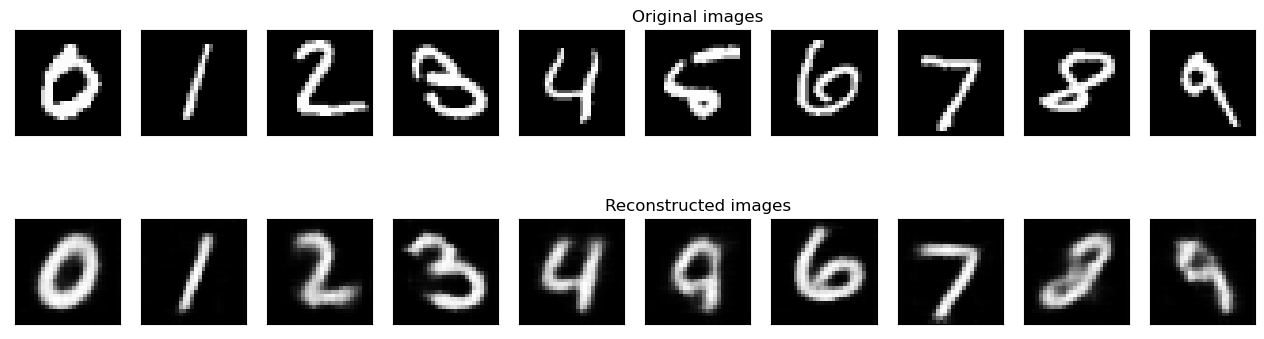

	 partial train loss (single batch): 8251.637695
	 partial train loss (single batch): 8756.105469
	 partial train loss (single batch): 8065.319336
	 partial train loss (single batch): 8003.383789
	 partial train loss (single batch): 8473.595703
	 partial train loss (single batch): 8533.482422
	 partial train loss (single batch): 8365.839844
	 partial train loss (single batch): 8478.278320
	 partial train loss (single batch): 8517.018555
	 partial train loss (single batch): 8445.800781
	 partial train loss (single batch): 8497.269531
	 partial train loss (single batch): 8343.338867
	 partial train loss (single batch): 8642.210938
	 partial train loss (single batch): 8140.176758
	 partial train loss (single batch): 8119.615234
	 partial train loss (single batch): 8487.597656
	 partial train loss (single batch): 8750.208984
	 partial train loss (single batch): 8091.554199
	 partial train loss (single batch): 8300.128906
	 partial train loss (single batch): 8365.552734
	 partial train loss

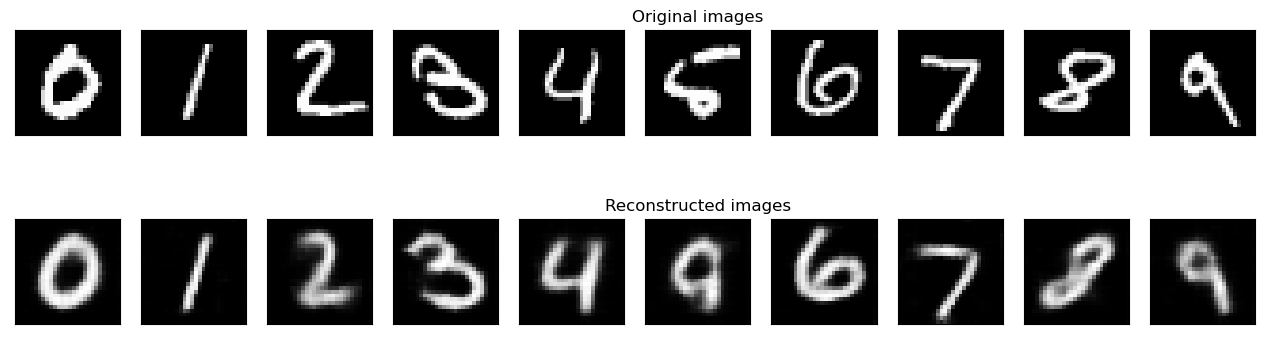

	 partial train loss (single batch): 8338.000977
	 partial train loss (single batch): 8869.232422
	 partial train loss (single batch): 8002.456055
	 partial train loss (single batch): 8066.009766
	 partial train loss (single batch): 8482.509766
	 partial train loss (single batch): 8550.830078
	 partial train loss (single batch): 8368.956055
	 partial train loss (single batch): 8467.763672
	 partial train loss (single batch): 8497.335938
	 partial train loss (single batch): 8492.609375
	 partial train loss (single batch): 8431.364258
	 partial train loss (single batch): 8302.444336
	 partial train loss (single batch): 8618.210938
	 partial train loss (single batch): 8131.039062
	 partial train loss (single batch): 8093.126953
	 partial train loss (single batch): 8489.339844
	 partial train loss (single batch): 8722.103516
	 partial train loss (single batch): 8070.014160
	 partial train loss (single batch): 8302.509766
	 partial train loss (single batch): 8307.436523
	 partial train loss

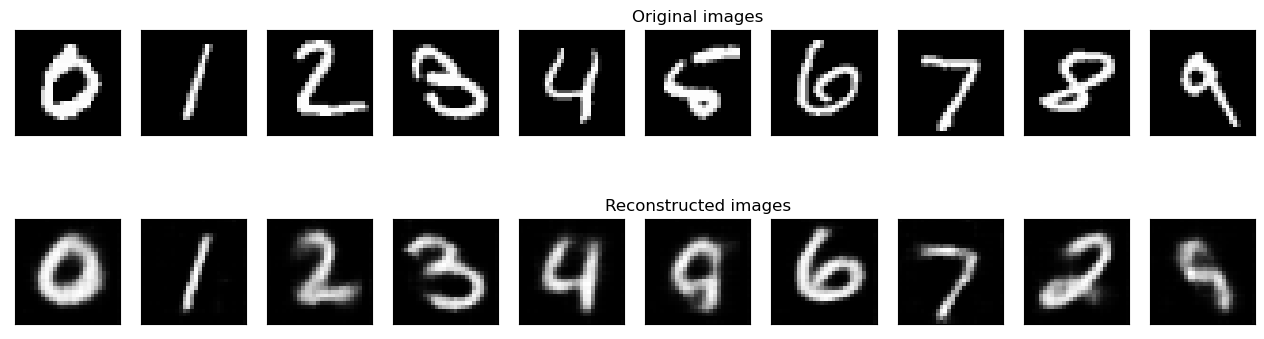

	 partial train loss (single batch): 8247.859375
	 partial train loss (single batch): 8802.432617
	 partial train loss (single batch): 7917.895020
	 partial train loss (single batch): 8011.379395
	 partial train loss (single batch): 8459.596680
	 partial train loss (single batch): 8495.113281
	 partial train loss (single batch): 8298.361328
	 partial train loss (single batch): 8491.692383
	 partial train loss (single batch): 8531.613281
	 partial train loss (single batch): 8386.713867
	 partial train loss (single batch): 8484.792969
	 partial train loss (single batch): 8380.945312
	 partial train loss (single batch): 8536.960938
	 partial train loss (single batch): 8148.796875
	 partial train loss (single batch): 8099.303223
	 partial train loss (single batch): 8460.422852
	 partial train loss (single batch): 8764.556641
	 partial train loss (single batch): 8004.626465
	 partial train loss (single batch): 8284.617188
	 partial train loss (single batch): 8342.424805
	 partial train loss

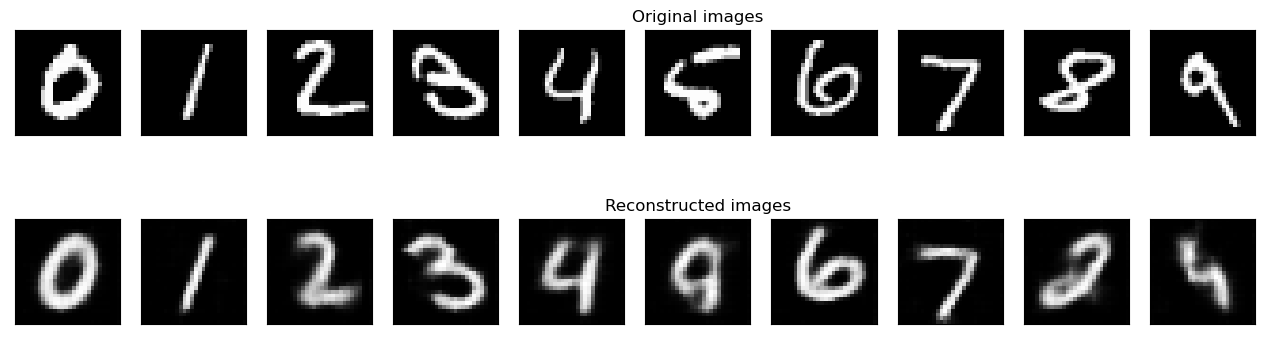

	 partial train loss (single batch): 8280.731445
	 partial train loss (single batch): 8853.275391
	 partial train loss (single batch): 7906.712891
	 partial train loss (single batch): 8029.260254
	 partial train loss (single batch): 8437.193359
	 partial train loss (single batch): 8427.916992
	 partial train loss (single batch): 8301.279297
	 partial train loss (single batch): 8466.825195
	 partial train loss (single batch): 8498.466797
	 partial train loss (single batch): 8369.807617
	 partial train loss (single batch): 8441.582031
	 partial train loss (single batch): 8287.415039
	 partial train loss (single batch): 8598.200195
	 partial train loss (single batch): 8131.293945
	 partial train loss (single batch): 8151.302734
	 partial train loss (single batch): 8442.785156
	 partial train loss (single batch): 8753.205078
	 partial train loss (single batch): 7999.941895
	 partial train loss (single batch): 8250.054688
	 partial train loss (single batch): 8275.574219
	 partial train loss

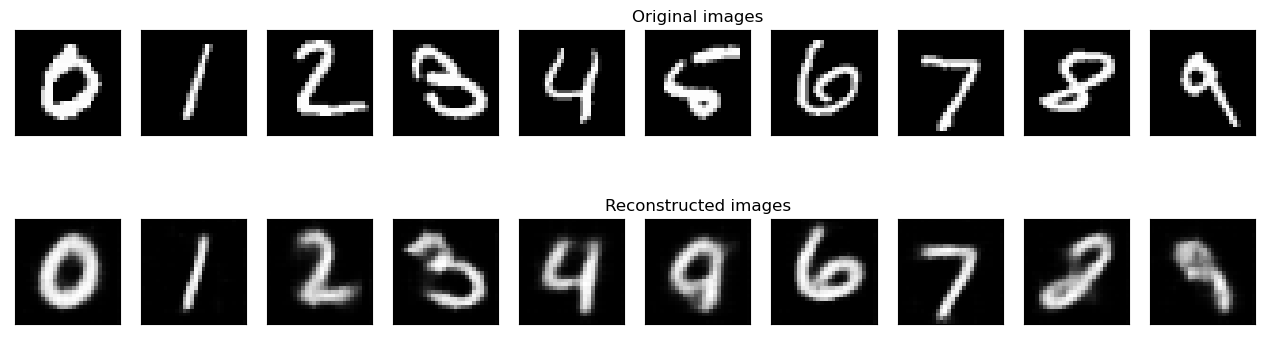

	 partial train loss (single batch): 8234.200195
	 partial train loss (single batch): 8778.323242
	 partial train loss (single batch): 7921.389648
	 partial train loss (single batch): 7922.282227
	 partial train loss (single batch): 8488.649414
	 partial train loss (single batch): 8445.608398
	 partial train loss (single batch): 8284.701172
	 partial train loss (single batch): 8376.699219
	 partial train loss (single batch): 8493.168945
	 partial train loss (single batch): 8427.533203
	 partial train loss (single batch): 8414.052734
	 partial train loss (single batch): 8242.148438
	 partial train loss (single batch): 8566.414062
	 partial train loss (single batch): 8097.041504
	 partial train loss (single batch): 8110.561523
	 partial train loss (single batch): 8499.614258
	 partial train loss (single batch): 8746.998047
	 partial train loss (single batch): 8072.153320
	 partial train loss (single batch): 8338.500000
	 partial train loss (single batch): 8366.603516
	 partial train loss

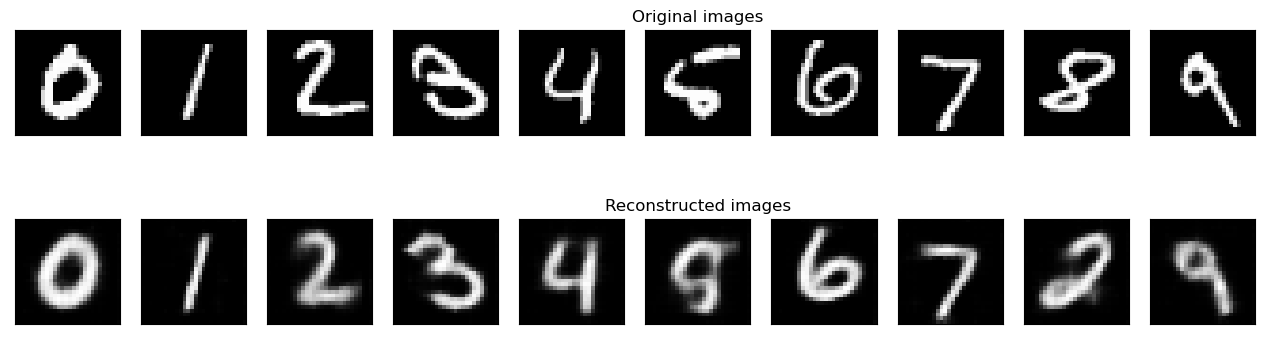

	 partial train loss (single batch): 8285.077148
	 partial train loss (single batch): 8756.585938
	 partial train loss (single batch): 7956.083496
	 partial train loss (single batch): 8001.866699
	 partial train loss (single batch): 8424.262695
	 partial train loss (single batch): 8458.710938
	 partial train loss (single batch): 8296.524414
	 partial train loss (single batch): 8417.089844
	 partial train loss (single batch): 8471.687500
	 partial train loss (single batch): 8466.994141
	 partial train loss (single batch): 8463.136719
	 partial train loss (single batch): 8238.556641
	 partial train loss (single batch): 8581.789062
	 partial train loss (single batch): 8048.112793
	 partial train loss (single batch): 8085.637695
	 partial train loss (single batch): 8439.587891
	 partial train loss (single batch): 8820.634766
	 partial train loss (single batch): 8022.118164
	 partial train loss (single batch): 8292.894531
	 partial train loss (single batch): 8337.068359
	 partial train loss

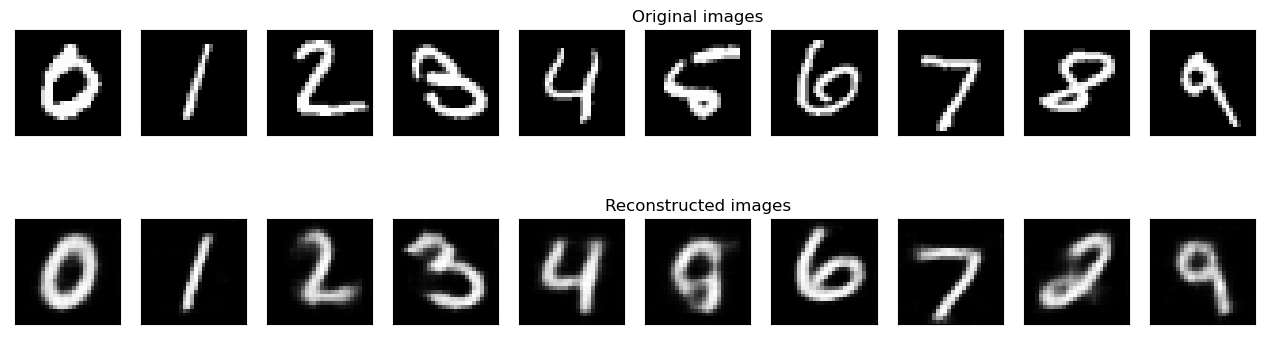

	 partial train loss (single batch): 8283.905273
	 partial train loss (single batch): 8687.044922
	 partial train loss (single batch): 7900.971680
	 partial train loss (single batch): 7935.355469
	 partial train loss (single batch): 8387.417969
	 partial train loss (single batch): 8383.412109
	 partial train loss (single batch): 8375.384766
	 partial train loss (single batch): 8459.777344
	 partial train loss (single batch): 8492.445312
	 partial train loss (single batch): 8472.177734
	 partial train loss (single batch): 8497.738281
	 partial train loss (single batch): 8298.490234
	 partial train loss (single batch): 8639.803711
	 partial train loss (single batch): 8074.943848
	 partial train loss (single batch): 8127.726074
	 partial train loss (single batch): 8453.258789
	 partial train loss (single batch): 8763.942383
	 partial train loss (single batch): 8010.326172
	 partial train loss (single batch): 8241.692383
	 partial train loss (single batch): 8264.064453
	 partial train loss

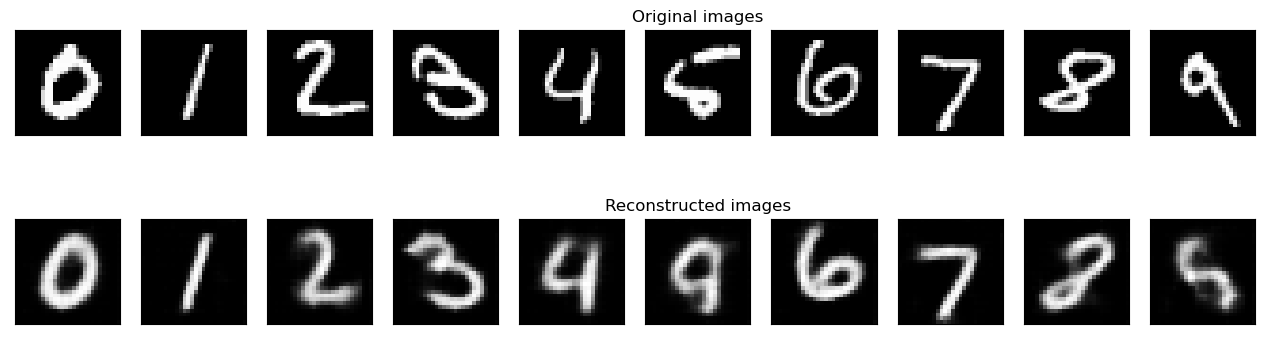

	 partial train loss (single batch): 8250.824219
	 partial train loss (single batch): 8707.075195
	 partial train loss (single batch): 7927.851074
	 partial train loss (single batch): 7975.346680
	 partial train loss (single batch): 8509.767578
	 partial train loss (single batch): 8404.252930
	 partial train loss (single batch): 8223.011719
	 partial train loss (single batch): 8408.739258
	 partial train loss (single batch): 8404.599609
	 partial train loss (single batch): 8338.583984
	 partial train loss (single batch): 8387.581055
	 partial train loss (single batch): 8172.303711
	 partial train loss (single batch): 8531.386719
	 partial train loss (single batch): 8036.386719
	 partial train loss (single batch): 8088.664062
	 partial train loss (single batch): 8485.708984
	 partial train loss (single batch): 8720.912109
	 partial train loss (single batch): 7986.144531
	 partial train loss (single batch): 8246.608398
	 partial train loss (single batch): 8283.739258
	 partial train loss

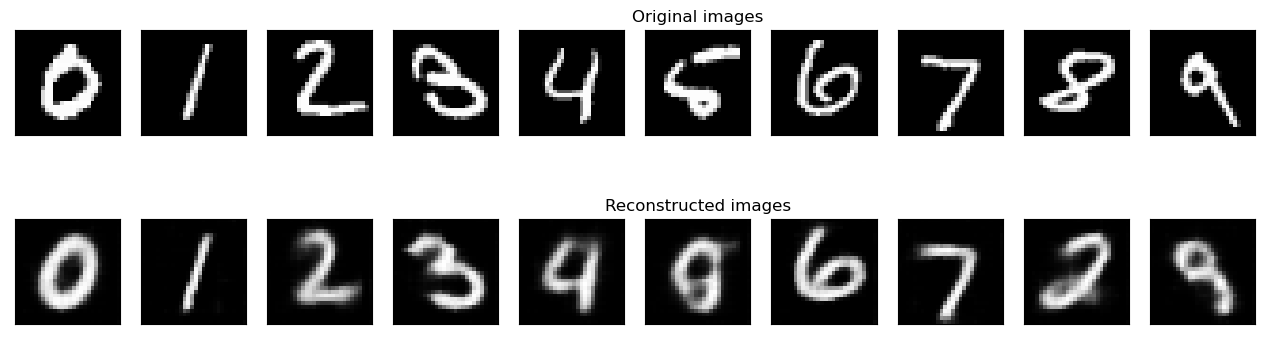

	 partial train loss (single batch): 8164.012695
	 partial train loss (single batch): 8787.488281
	 partial train loss (single batch): 7908.698242
	 partial train loss (single batch): 7984.785156
	 partial train loss (single batch): 8391.960938
	 partial train loss (single batch): 8354.142578
	 partial train loss (single batch): 8231.230469
	 partial train loss (single batch): 8486.920898
	 partial train loss (single batch): 8507.474609
	 partial train loss (single batch): 8429.443359
	 partial train loss (single batch): 8423.658203
	 partial train loss (single batch): 8293.265625
	 partial train loss (single batch): 8529.926758
	 partial train loss (single batch): 8035.310547
	 partial train loss (single batch): 8100.724121
	 partial train loss (single batch): 8482.876953
	 partial train loss (single batch): 8698.939453
	 partial train loss (single batch): 7995.147949
	 partial train loss (single batch): 8236.455078
	 partial train loss (single batch): 8224.437500
	 partial train loss

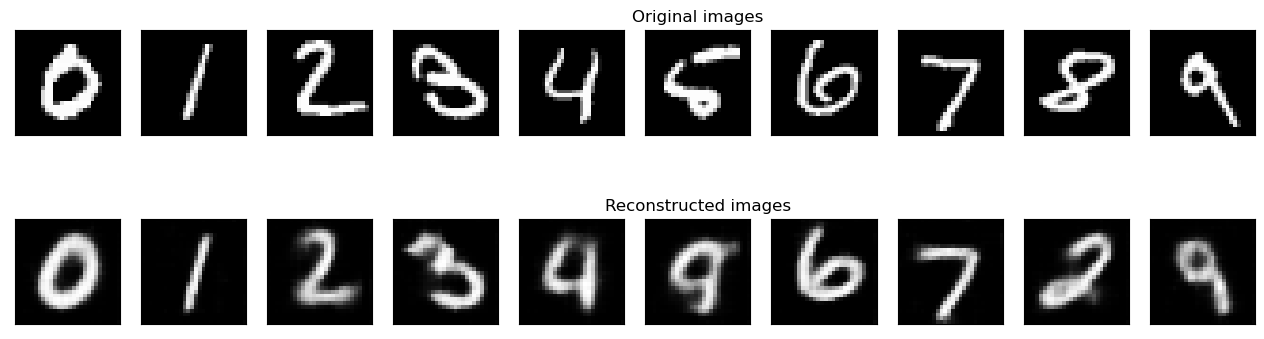

	 partial train loss (single batch): 8175.730469
	 partial train loss (single batch): 8719.607422
	 partial train loss (single batch): 7994.526855
	 partial train loss (single batch): 7944.758301
	 partial train loss (single batch): 8426.503906
	 partial train loss (single batch): 8351.156250
	 partial train loss (single batch): 8302.116211
	 partial train loss (single batch): 8384.355469
	 partial train loss (single batch): 8494.710938
	 partial train loss (single batch): 8329.413086
	 partial train loss (single batch): 8380.782227
	 partial train loss (single batch): 8223.931641
	 partial train loss (single batch): 8452.439453
	 partial train loss (single batch): 8062.673828
	 partial train loss (single batch): 8031.437988
	 partial train loss (single batch): 8487.300781
	 partial train loss (single batch): 8707.049805
	 partial train loss (single batch): 7957.009277
	 partial train loss (single batch): 8185.019531
	 partial train loss (single batch): 8266.776367
	 partial train loss

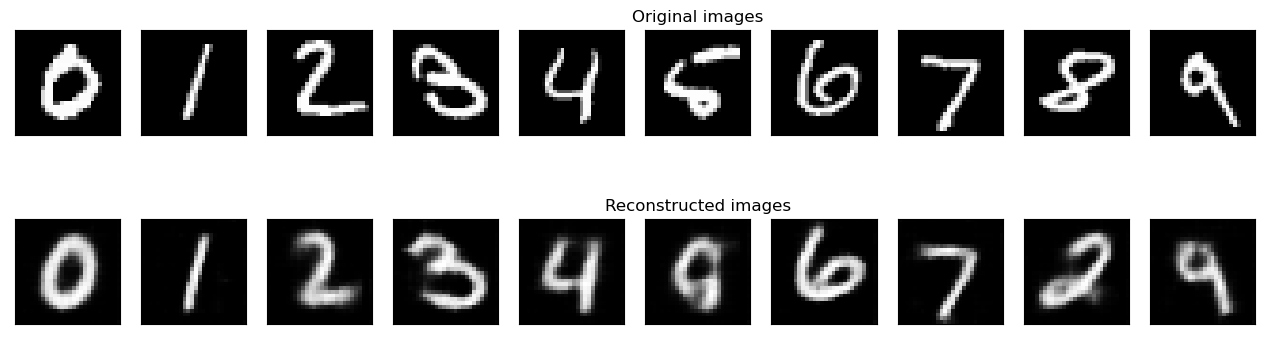

	 partial train loss (single batch): 8263.412109
	 partial train loss (single batch): 8777.123047
	 partial train loss (single batch): 7962.020508
	 partial train loss (single batch): 7905.247559
	 partial train loss (single batch): 8420.336914
	 partial train loss (single batch): 8479.789062
	 partial train loss (single batch): 8281.125000
	 partial train loss (single batch): 8352.437500
	 partial train loss (single batch): 8429.718750
	 partial train loss (single batch): 8391.050781
	 partial train loss (single batch): 8476.497070
	 partial train loss (single batch): 8184.435547
	 partial train loss (single batch): 8565.982422
	 partial train loss (single batch): 8093.958984
	 partial train loss (single batch): 8045.847168
	 partial train loss (single batch): 8466.880859
	 partial train loss (single batch): 8662.881836
	 partial train loss (single batch): 7962.476562
	 partial train loss (single batch): 8224.507812
	 partial train loss (single batch): 8300.025391
	 partial train loss

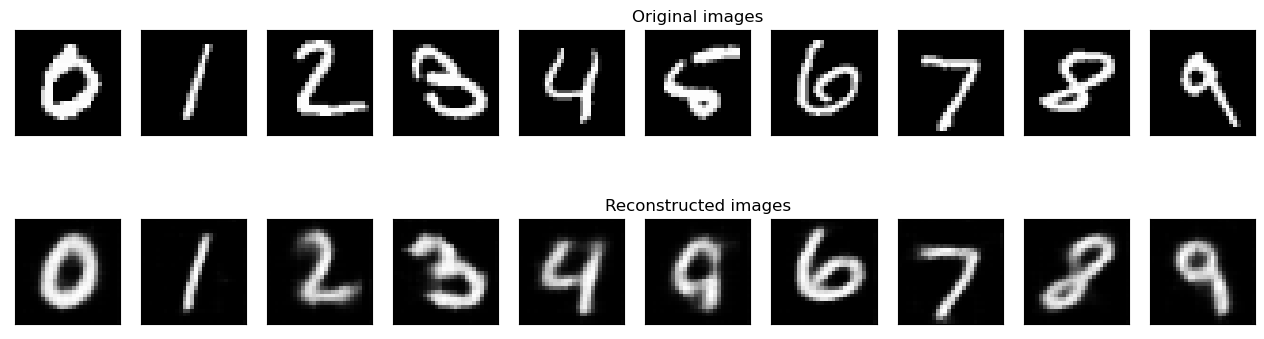

	 partial train loss (single batch): 8224.078125
	 partial train loss (single batch): 8774.361328
	 partial train loss (single batch): 7913.890137
	 partial train loss (single batch): 7916.022949
	 partial train loss (single batch): 8395.968750
	 partial train loss (single batch): 8426.797852
	 partial train loss (single batch): 8273.580078
	 partial train loss (single batch): 8402.425781
	 partial train loss (single batch): 8436.559570
	 partial train loss (single batch): 8498.129883
	 partial train loss (single batch): 8333.500977
	 partial train loss (single batch): 8245.265625
	 partial train loss (single batch): 8468.537109
	 partial train loss (single batch): 8023.597168
	 partial train loss (single batch): 8096.048828
	 partial train loss (single batch): 8378.561523
	 partial train loss (single batch): 8749.023438
	 partial train loss (single batch): 8008.485352
	 partial train loss (single batch): 8235.962891
	 partial train loss (single batch): 8233.757812
	 partial train loss

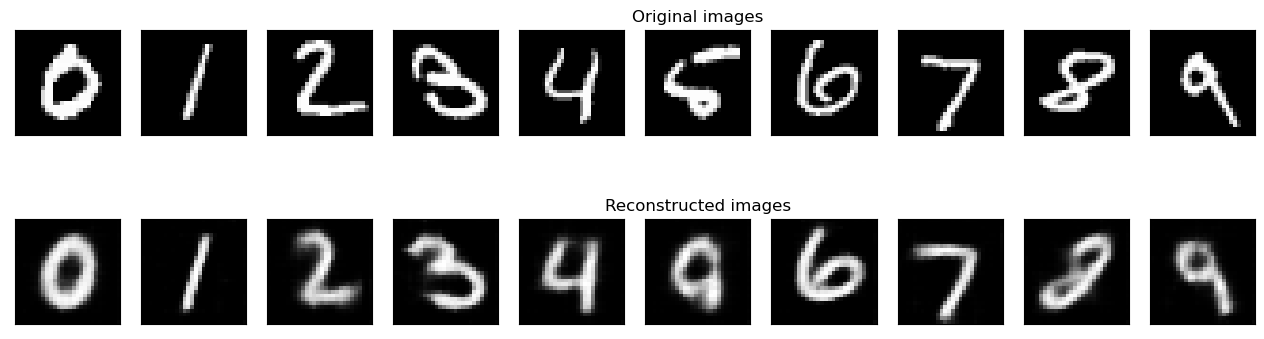

	 partial train loss (single batch): 8197.951172
	 partial train loss (single batch): 8707.578125
	 partial train loss (single batch): 7894.268066
	 partial train loss (single batch): 7910.962891
	 partial train loss (single batch): 8474.540039
	 partial train loss (single batch): 8464.506836
	 partial train loss (single batch): 8291.116211
	 partial train loss (single batch): 8416.539062
	 partial train loss (single batch): 8491.255859
	 partial train loss (single batch): 8488.676758
	 partial train loss (single batch): 8439.602539
	 partial train loss (single batch): 8284.631836
	 partial train loss (single batch): 8529.814453
	 partial train loss (single batch): 8061.918945
	 partial train loss (single batch): 8052.105469
	 partial train loss (single batch): 8432.141602
	 partial train loss (single batch): 8777.707031
	 partial train loss (single batch): 7971.826172
	 partial train loss (single batch): 8255.906250
	 partial train loss (single batch): 8346.437500
	 partial train loss

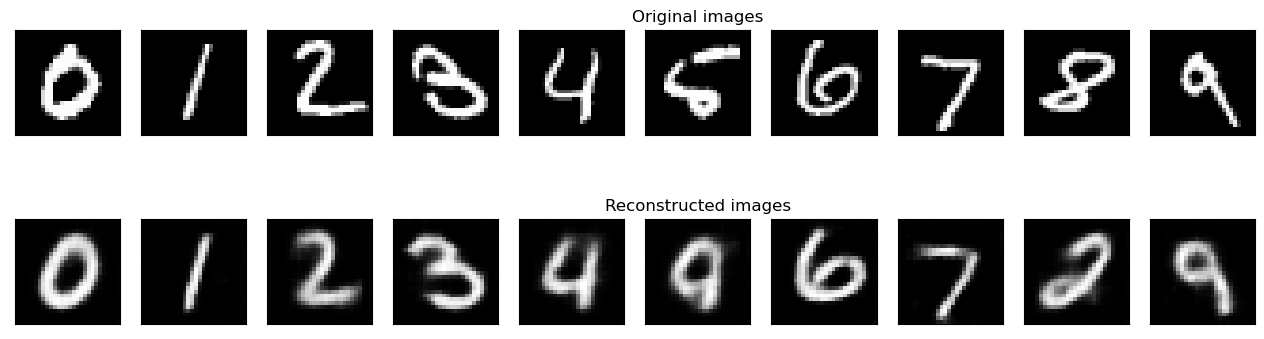

	 partial train loss (single batch): 8195.576172
	 partial train loss (single batch): 8704.378906
	 partial train loss (single batch): 7808.507324
	 partial train loss (single batch): 7901.465820
	 partial train loss (single batch): 8359.951172
	 partial train loss (single batch): 8326.120117
	 partial train loss (single batch): 8170.937500
	 partial train loss (single batch): 8506.762695
	 partial train loss (single batch): 8414.036133
	 partial train loss (single batch): 8321.513672
	 partial train loss (single batch): 8352.991211
	 partial train loss (single batch): 8188.747070
	 partial train loss (single batch): 8511.040039
	 partial train loss (single batch): 8009.409668
	 partial train loss (single batch): 8051.996094
	 partial train loss (single batch): 8430.402344
	 partial train loss (single batch): 8698.519531
	 partial train loss (single batch): 8031.407227
	 partial train loss (single batch): 8176.510254
	 partial train loss (single batch): 8316.401367
	 partial train loss

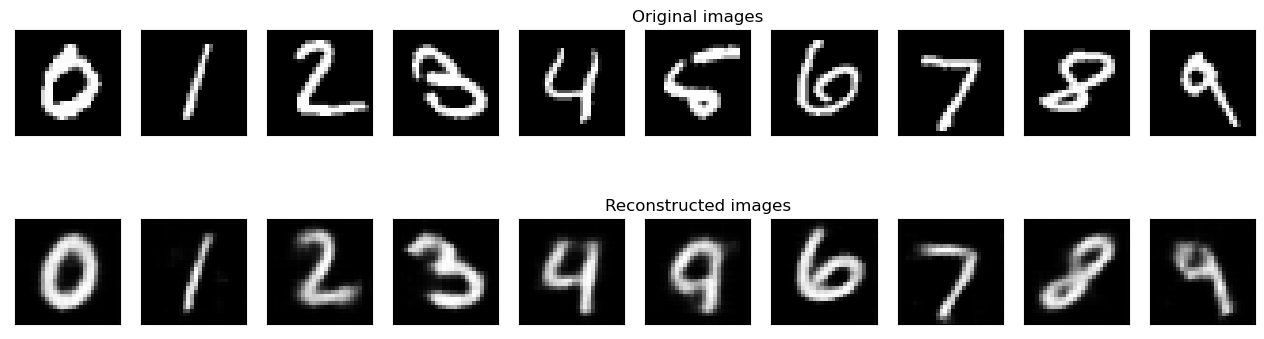

	 partial train loss (single batch): 8193.480469
	 partial train loss (single batch): 8706.463867
	 partial train loss (single batch): 7868.041016
	 partial train loss (single batch): 7992.072266
	 partial train loss (single batch): 8431.595703
	 partial train loss (single batch): 8354.230469
	 partial train loss (single batch): 8288.087891
	 partial train loss (single batch): 8307.952148
	 partial train loss (single batch): 8419.633789
	 partial train loss (single batch): 8338.851562
	 partial train loss (single batch): 8345.195312
	 partial train loss (single batch): 8174.353516
	 partial train loss (single batch): 8422.336914
	 partial train loss (single batch): 7947.017578
	 partial train loss (single batch): 8098.126953
	 partial train loss (single batch): 8325.556641
	 partial train loss (single batch): 8737.940430
	 partial train loss (single batch): 7969.600098
	 partial train loss (single batch): 8157.360840
	 partial train loss (single batch): 8322.556641
	 partial train loss

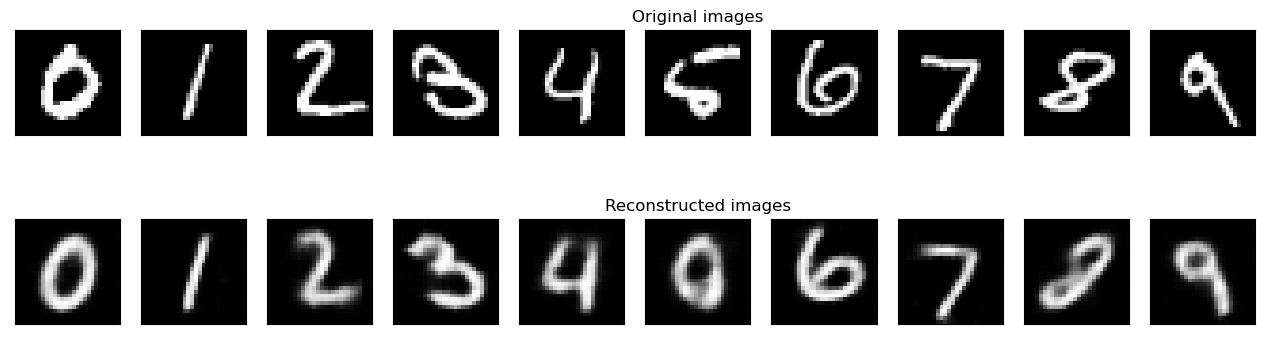

	 partial train loss (single batch): 8188.618164
	 partial train loss (single batch): 8628.246094
	 partial train loss (single batch): 7844.529297
	 partial train loss (single batch): 7969.558105
	 partial train loss (single batch): 8426.277344
	 partial train loss (single batch): 8419.636719
	 partial train loss (single batch): 8290.958008
	 partial train loss (single batch): 8340.880859
	 partial train loss (single batch): 8399.635742
	 partial train loss (single batch): 8366.473633
	 partial train loss (single batch): 8407.011719
	 partial train loss (single batch): 8166.965332
	 partial train loss (single batch): 8387.169922
	 partial train loss (single batch): 7918.970703
	 partial train loss (single batch): 7994.541016
	 partial train loss (single batch): 8362.705078
	 partial train loss (single batch): 8656.144531
	 partial train loss (single batch): 8017.770996
	 partial train loss (single batch): 8255.392578
	 partial train loss (single batch): 8248.644531
	 partial train loss

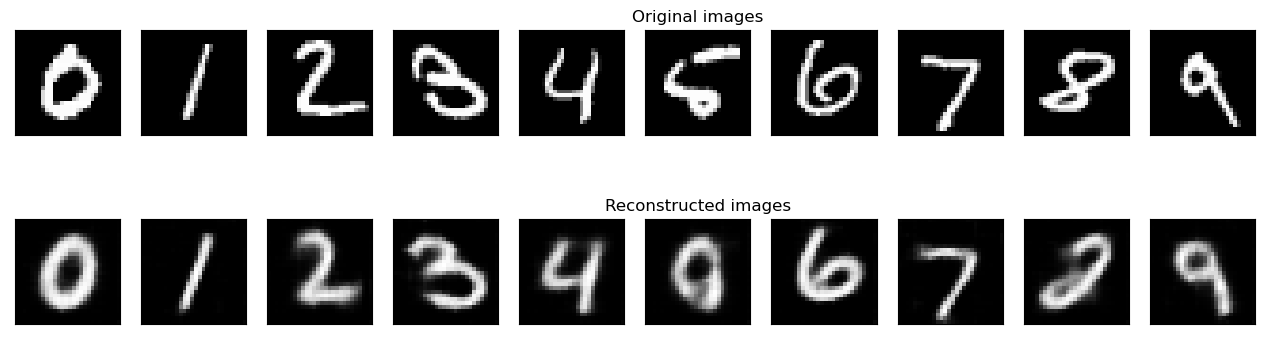

	 partial train loss (single batch): 8171.841797
	 partial train loss (single batch): 8664.184570
	 partial train loss (single batch): 7868.996582
	 partial train loss (single batch): 7844.512695
	 partial train loss (single batch): 8446.166016
	 partial train loss (single batch): 8358.306641
	 partial train loss (single batch): 8213.533203
	 partial train loss (single batch): 8431.826172
	 partial train loss (single batch): 8403.828125
	 partial train loss (single batch): 8353.625000
	 partial train loss (single batch): 8335.247070
	 partial train loss (single batch): 8092.549805
	 partial train loss (single batch): 8435.891602
	 partial train loss (single batch): 8007.851562
	 partial train loss (single batch): 8050.870605
	 partial train loss (single batch): 8316.882812
	 partial train loss (single batch): 8704.124023
	 partial train loss (single batch): 7935.702148
	 partial train loss (single batch): 8200.932617
	 partial train loss (single batch): 8213.154297
	 partial train loss

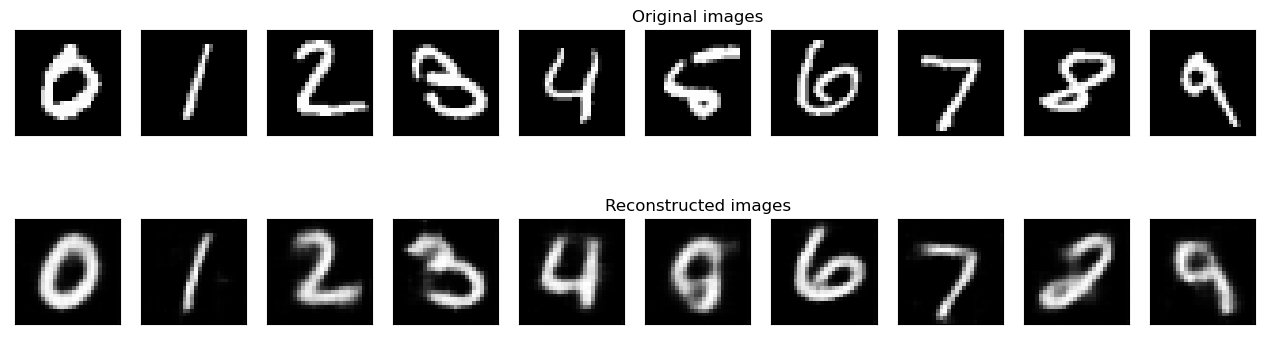

In [13]:
num_epochs = 50

for epoch in range(num_epochs):
   train_loss = train_epoch(vae,device,train_loader,optim)
   val_loss = test_epoch(vae,device,valid_loader)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   plot_ae_outputs(vae.encoder,vae.decoder,n=10)

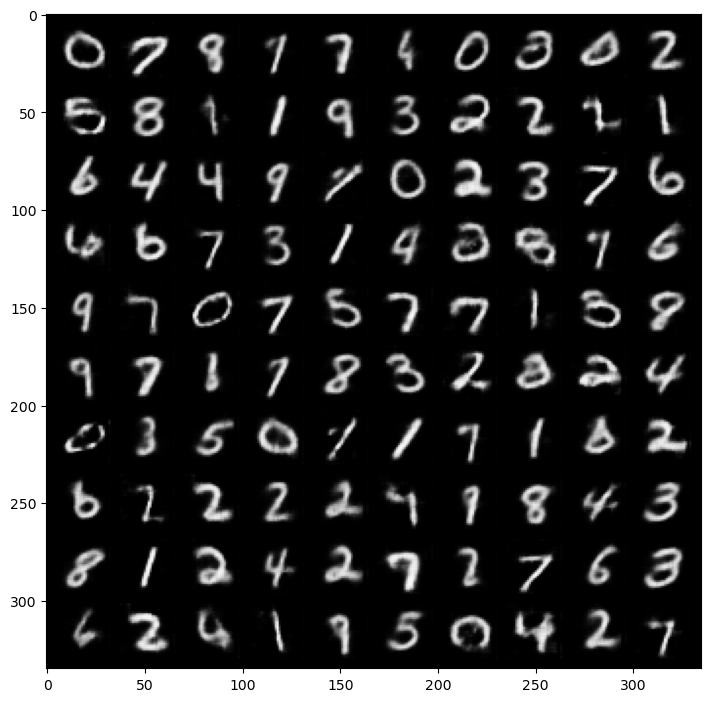

In [14]:
# generate new images by drawing latent vectors from the prior distribution


def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


vae.eval()

with torch.no_grad():

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, d, device=device)

    # reconstruct images from the latent vectors
    img_recon = vae.decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon.data[:100],10,5))
    plt.show()

## visualize latent code

In [23]:
from tqdm import tqdm
from sklearn.manifold import TSNE
import plotly.express as px

In [24]:
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    vae.eval()
    with torch.no_grad():
        encoded_img  = vae.encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
    
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples


px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)


100%|██████████| 10000/10000 [00:11<00:00, 908.97it/s]


In [25]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()